In [1]:
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import keras
import pickle

from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.initializers import Ones, Zeros, Constant
from keras.models import Model, load_model
from keras.layers import Dense, Input, Lambda, SimpleRNN, Reshape, RepeatVector, PReLU, BatchNormalization, LeakyReLU
from keras.losses import mse
from keras.constraints import non_neg

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Change presentation settings

%matplotlib inline

matplotlib.rcParams["figure.figsize"] = (16.0, 10.0)

#matplotlib.rcParams['font.family'] = 'sans-serif'
#matplotlib.rcParams['font.sans-serif'] = ['Liberation Sans']

matplotlib.rcParams["axes.spines.left"] = True
matplotlib.rcParams["axes.spines.top"] = True
matplotlib.rcParams["axes.spines.right"] = True
matplotlib.rcParams["axes.spines.bottom"] = True
matplotlib.rcParams["axes.labelsize"] = 18
matplotlib.rcParams["axes.titlesize"] = 12

matplotlib.rcParams["xtick.top"] = True
matplotlib.rcParams["ytick.right"] = True
matplotlib.rcParams["xtick.direction"] = "in"
matplotlib.rcParams["ytick.direction"] = "in"
matplotlib.rcParams["xtick.labelsize"] = 10
matplotlib.rcParams["ytick.labelsize"] = 10
matplotlib.rcParams["xtick.major.size"] = 10
matplotlib.rcParams["ytick.major.size"] = 10
matplotlib.rcParams["xtick.minor.size"] = 5
matplotlib.rcParams["ytick.minor.size"] = 5
matplotlib.rcParams["xtick.minor.visible"] = True

matplotlib.rcParams["lines.linewidth"] = 2

matplotlib.rcParams["legend.fontsize"] = 14

color_palette = {"Indigo": {
                    50: "#E8EAF6",
                    100: "#C5CAE9",
                    200: "#9FA8DA",
                    300: "#7986CB",
                    400: "#5C6BC0",
                    500: "#3F51B5",
                    600: "#3949AB",
                    700: "#303F9F",
                    800: "#283593",
                    900: "#1A237E"},
                 "Orange": {      
                    50: "#FFF3E0",
                    100: "#FFE0B2",
                    200: "#FFCC80",
                    300: "#FFB74D",
                    400: "#FFA726",
                    500: "#FF9800",
                    600: "#FB8C00",
                    700: "#F57C00",
                    800: "#EF6C00",
                    900: "#E65100"}
                }

line_styles = [(0, ()), (0, (1, 2)), (0, (3, 2))]

In [3]:
def plot_loss(data, save_name=False):
    """Plots the training and validation loss"""
    fig, ax = plt.subplots()

    plt.xlabel("Epoch", horizontalalignment='right', x=1.0)
    plt.ylabel("Cross-entropy", horizontalalignment='right', y=1.0)

    plt.plot(data["loss"], linestyle=line_styles[0], color=color_palette["Indigo"][800])
    plt.plot(data["val_loss"], linestyle=line_styles[2], color=color_palette["Orange"][400])
    plt.legend(["Training data set", "Validation data set"], loc="upper right", frameon=False)
    #plt.yscale("log")
    
    if save_name:
        fig.savefig("%s/%s.eps" % (figure_export_directory, save_name), bbox_inches="tight")

    plt.show();

In [16]:
def train_nn(model, x, y, batch_size, loss, name, xval):

    adam = keras.optimizers.Adam(lr=0.003,
                                 beta_1=0.9,
                                 beta_2=0.999,
                                 epsilon=None,
                                 decay=0.0,
                                 amsgrad=False)

    early_stopper = EarlyStopping(monitor="val_loss",
                                  patience=32,
                                  verbose=True,
                                  mode="auto")

    reduce_lr = ReduceLROnPlateau(monitor="val_loss",
                                  factor=0.1,
                                  patience=24)
    
    checkpoint_callback = ModelCheckpoint(("%s.h5" % (name)),
                                          monitor="val_loss",
                                          verbose=False,
                                          save_best_only=True,
                                          mode="min")
    
    model.compile(loss=loss, optimizer=adam)
    
    history = model.fit(x, y,
                     batch_size=batch_size,
                     epochs=8000,
                     verbose=2,
                     initial_epoch=0,
                     shuffle=True,
                     validation_data=(xval,xval),
                     callbacks=[early_stopper, checkpoint_callback])
    return history

## Data

In [17]:
runs = [304125,304508,302263]

with open('normedAvg_data.pickle', 'rb') as handle:
    data = pickle.load(handle)
with open('normedAvg_bad.pickle', 'rb') as handle:
    bad_data = pickle.load(handle)

x_train = np.array(data[str(runs[0])]['samples'])
x_val = np.array(data[str(runs[1])]['samples'])
x_test = np.array(data[str(runs[2])]['samples'])

x_bad1 = np.array(bad_data['301480']['samples'])
x_bad2 = np.array(bad_data['305588']['samples'])

WINDOW = 1

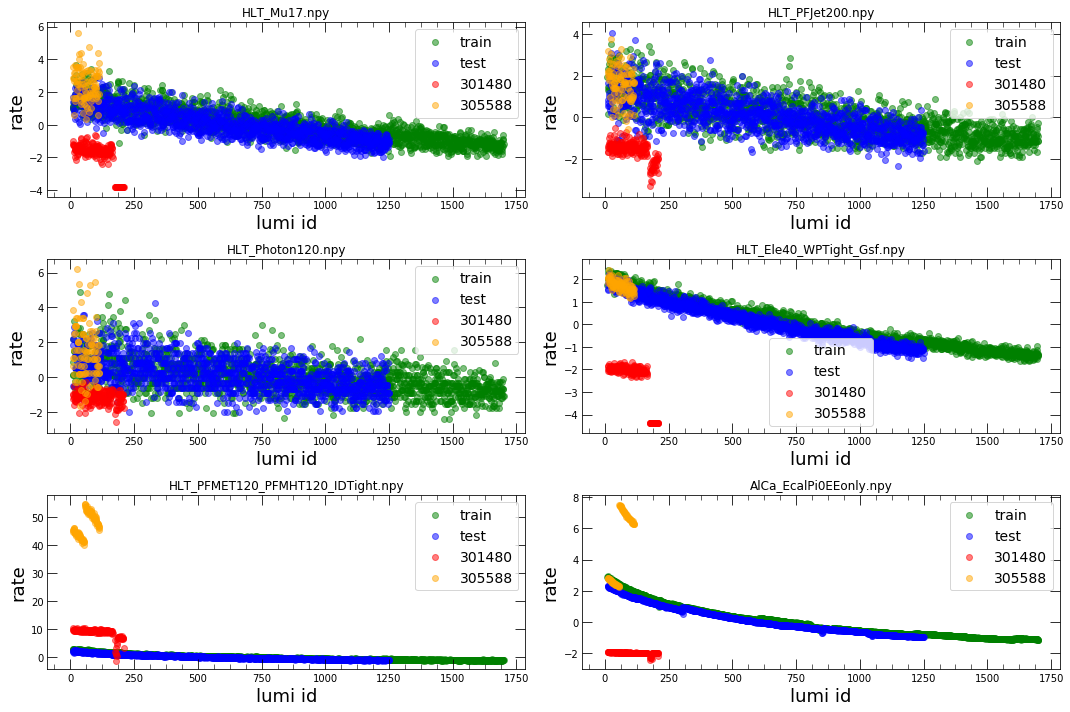

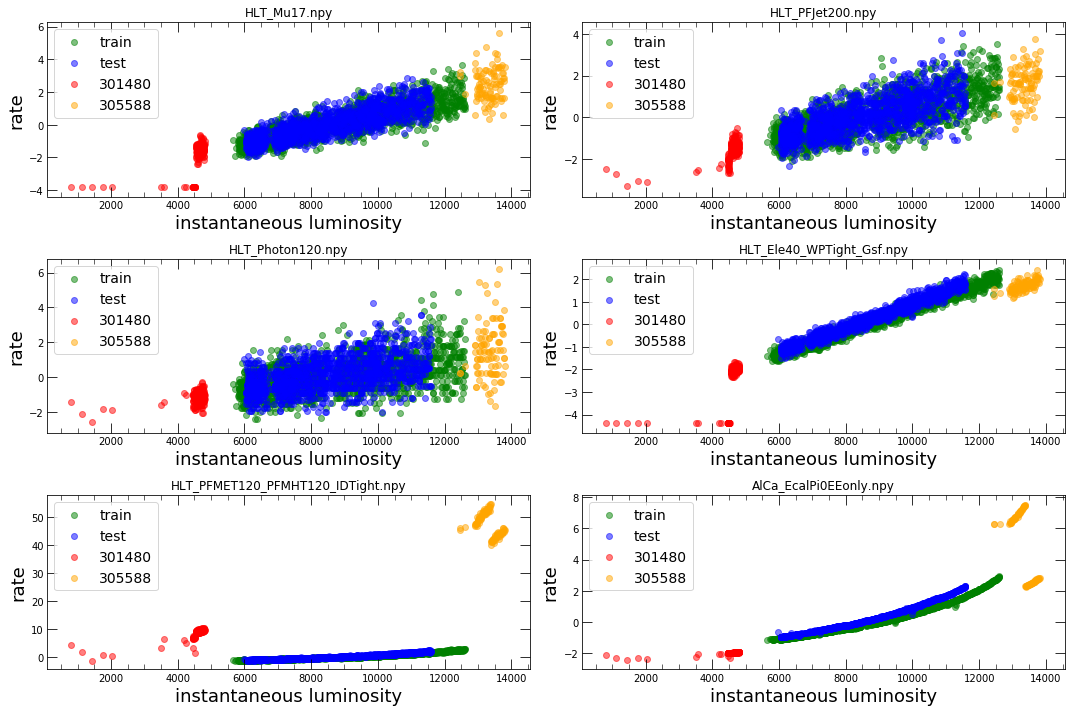

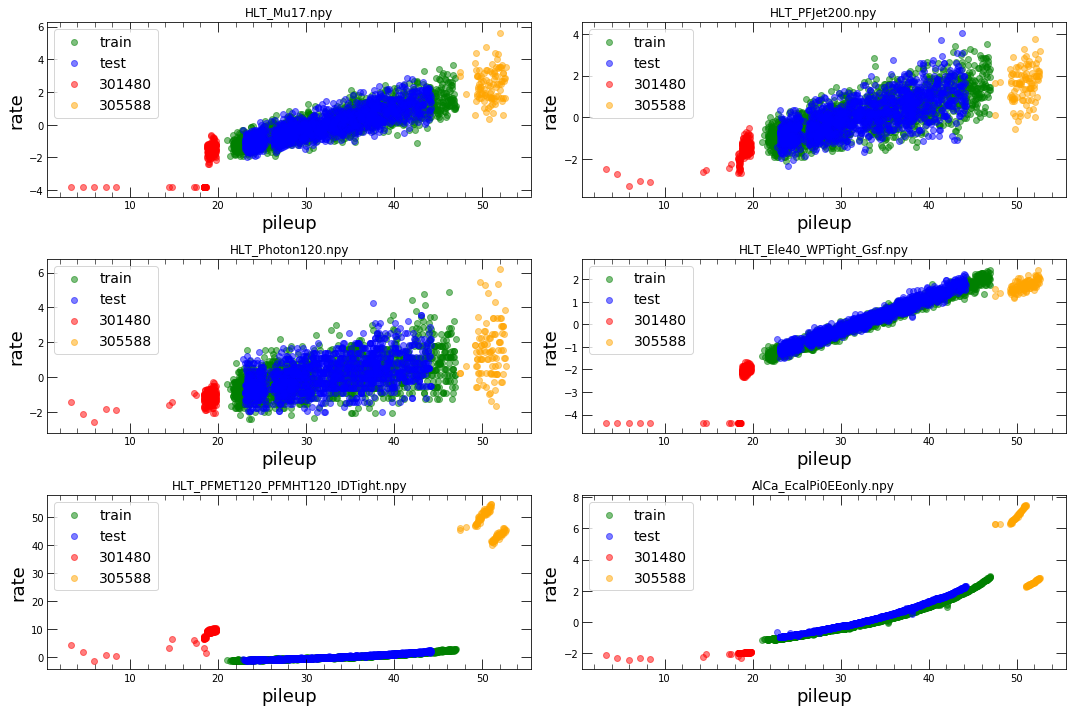

In [18]:
plots = [x_train,x_test,x_bad1,x_bad2]
titles = ["train","test","301480","305588"]

stuff = [[],[],[],[]]
lumi = [[],[],[],[]]
inst = [[],[],[],[]]
pileup = [[],[],[],[]]
for h in range(4):
    if h == 0 or h == 1:
        lumi[h] = data[str(runs[h])]['lumiid']
        inst[h] = data[str(runs[h])]['instlumi']
        pileup[h] = data[str(runs[h])]['pileup']
        stuff[h] = data[str(runs[h])]['rates']
    elif h == 2:
        lumi[h] = bad_data["301480"]['lumiid']
        inst[h] = bad_data["301480"]['instlumi']
        pileup[h] = bad_data["301480"]['pileup']
        stuff[h] = bad_data["301480"]['rates']
    else:
        lumi[h] = bad_data["305588"]['lumiid']
        inst[h] = bad_data["305588"]['instlumi']
        pileup[h] = bad_data["305588"]['pileup']
        stuff[h] = bad_data["305588"]['rates']
    
labels = data['HLT'] 
colors = ["g","b","r","orange"]
    
plt.figure(figsize=[15,10])
for i in range(6):
    plt.subplot(3,2,i+1)
    for k in range(0,4):
        #print(len(i[k]),len(stuff[k][i]))
        plt.scatter(lumi[k],stuff[k][i],c=colors[k],label=titles[k],alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('rate')
    plt.title(labels[i])
    plt.legend()

plt.tight_layout()

plt.figure(figsize=[15,10])
              
for i in range(6):
    plt.subplot(3,2,i+1)
    for k in range(0,4):
        #print(len(inst[k][i]),len(stuff[k][i]))
        plt.scatter(inst[k][i],stuff[k][i],c=colors[k],label=titles[k],alpha=.5)
    plt.xlabel('instantaneous luminosity')
    plt.ylabel('rate')
    plt.title(labels[i])
    plt.legend()

plt.tight_layout()

plt.figure(figsize=[15,10])
              
for i in range(6):
    plt.subplot(3,2,i+1)
    for k in range(0,4):
        #print(len(lumi[k]),len(stuff[k][i]))
        plt.scatter(pileup[k][i],stuff[k][i],c=colors[k],label=titles[k],alpha=.5)
    plt.xlabel('pileup')
    plt.ylabel('rate')
    plt.title(labels[i])
    plt.legend()

plt.tight_layout()

plt.show()

## Simple Autoencoder

In [19]:
model_name = "normavgmorelayers"

In [20]:
# Define the architecture

_input = Input(shape=(6,), name="input")

hidden1 = Dense(5,
               kernel_initializer=Ones(),
               bias_initializer=Zeros(),
               kernel_constraint=non_neg(),
               bias_constraint=non_neg(),
               name="hidden1")(_input)

active1 = LeakyReLU()(hidden1)

hidden2 = Dense(4,
               kernel_initializer=Ones(),
               bias_initializer=Zeros(),
               kernel_constraint=non_neg(),
               bias_constraint=non_neg(),
               name="hidden2")(active1)

active2 = LeakyReLU()(hidden2)

hidden3 = Dense(3,
               kernel_initializer=Ones(),
               bias_initializer=Zeros(),
               kernel_constraint=non_neg(),
               bias_constraint=non_neg(),
               name="encoded")(active2)

active3 = LeakyReLU()(hidden3)

hidden4 = Dense(4,
               kernel_initializer=Ones(),
               bias_initializer=Zeros(),
               kernel_constraint=non_neg(),
               bias_constraint=non_neg(),
               name="hidden4")(active3)

active4 = LeakyReLU()(hidden4)

hidden5 = Dense(5,
               kernel_initializer=Ones(),
               bias_initializer=Zeros(),
               kernel_constraint=non_neg(),
               bias_constraint=non_neg(),
               name="hidden5")(active4)

active5 = LeakyReLU()(hidden5)

output = Dense(6,
               kernel_initializer=Ones(),
               bias_initializer=Zeros(),
               kernel_constraint=non_neg(),
               bias_constraint=non_neg(),
               activation=None,
               name="reconstructed")(active5)

model = Model(_input, output)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 6)                 0         
_________________________________________________________________
hidden1 (Dense)              (None, 5)                 35        
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 5)                 0         
_________________________________________________________________
hidden2 (Dense)              (None, 4)                 24        
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 4)                 0         
_________________________________________________________________
encoded (Dense)              (None, 3)                 15        
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 3)                 0         
__________

Train on 1669 samples, validate on 1224 samples
Epoch 1/8000
 - 3s - loss: 3590289.8938 - val_loss: 3510972.5147
Epoch 2/8000
 - 0s - loss: 3341913.4700 - val_loss: 3265813.8088
Epoch 3/8000
 - 0s - loss: 3108833.7732 - val_loss: 3042659.4183
Epoch 4/8000
 - 0s - loss: 2896721.6860 - val_loss: 2832927.4804
Epoch 5/8000
 - 0s - loss: 2696769.9462 - val_loss: 2637518.8546
Epoch 6/8000
 - 0s - loss: 2509540.4987 - val_loss: 2456223.6511
Epoch 7/8000
 - 0s - loss: 2337413.4826 - val_loss: 2288864.5082
Epoch 8/8000
 - 0s - loss: 2178977.7167 - val_loss: 2134109.6193
Epoch 9/8000
 - 0s - loss: 2031597.0443 - val_loss: 1991141.7247
Epoch 10/8000
 - 0s - loss: 1895471.5640 - val_loss: 1860341.0895
Epoch 11/8000
 - 0s - loss: 1772389.1511 - val_loss: 1740774.4563
Epoch 12/8000
 - 0s - loss: 1659132.4196 - val_loss: 1631119.7145
Epoch 13/8000
 - 0s - loss: 1554289.0770 - val_loss: 1530018.6695
Epoch 14/8000
 - 0s - loss: 1458404.3226 - val_loss: 1437264.2377
Epoch 15/8000
 - 0s - loss: 1370221.8

Epoch 128/8000
 - 0s - loss: 79579.7976 - val_loss: 81653.9724
Epoch 129/8000
 - 0s - loss: 78577.1089 - val_loss: 80627.3326
Epoch 130/8000
 - 0s - loss: 77595.8802 - val_loss: 79619.4701
Epoch 131/8000
 - 0s - loss: 76624.8493 - val_loss: 78631.5583
Epoch 132/8000
 - 0s - loss: 75676.9581 - val_loss: 77663.0286
Epoch 133/8000
 - 0s - loss: 74741.8132 - val_loss: 76712.4276
Epoch 134/8000
 - 0s - loss: 73833.6584 - val_loss: 75779.3937
Epoch 135/8000
 - 0s - loss: 72935.3851 - val_loss: 74863.5139
Epoch 136/8000
 - 0s - loss: 72056.3829 - val_loss: 73963.9741
Epoch 137/8000
 - 0s - loss: 71190.5753 - val_loss: 73081.3071
Epoch 138/8000
 - 0s - loss: 70337.4726 - val_loss: 72215.7835
Epoch 139/8000
 - 0s - loss: 69507.2698 - val_loss: 71364.8604
Epoch 140/8000
 - 0s - loss: 68687.9798 - val_loss: 70528.9100
Epoch 141/8000
 - 0s - loss: 67884.1701 - val_loss: 69707.4397
Epoch 142/8000
 - 0s - loss: 67096.0366 - val_loss: 68900.5613
Epoch 143/8000
 - 0s - loss: 66321.4522 - val_loss: 681

Epoch 259/8000
 - 0s - loss: 23825.8885 - val_loss: 24561.0035
Epoch 260/8000
 - 0s - loss: 23662.4851 - val_loss: 24392.2613
Epoch 261/8000
 - 0s - loss: 23500.5574 - val_loss: 24225.2665
Epoch 262/8000
 - 0s - loss: 23339.4508 - val_loss: 24060.1638
Epoch 263/8000
 - 0s - loss: 23181.0165 - val_loss: 23896.6604
Epoch 264/8000
 - 0s - loss: 23023.3670 - val_loss: 23734.8709
Epoch 265/8000
 - 0s - loss: 22867.4886 - val_loss: 23574.7671
Epoch 266/8000
 - 0s - loss: 22713.5297 - val_loss: 23416.3239
Epoch 267/8000
 - 0s - loss: 22560.6079 - val_loss: 23259.5367
Epoch 268/8000
 - 0s - loss: 22410.2043 - val_loss: 23104.1880
Epoch 269/8000
 - 0s - loss: 22259.9092 - val_loss: 22950.5058
Epoch 270/8000
 - 0s - loss: 22111.1635 - val_loss: 22798.3013
Epoch 271/8000
 - 0s - loss: 21965.1052 - val_loss: 22647.3762
Epoch 272/8000
 - 0s - loss: 21820.0752 - val_loss: 22497.8887
Epoch 273/8000
 - 0s - loss: 21676.7764 - val_loss: 22349.8431
Epoch 274/8000
 - 0s - loss: 21534.4521 - val_loss: 222

Epoch 390/8000
 - 0s - loss: 11240.6157 - val_loss: 11606.3083
Epoch 391/8000
 - 0s - loss: 11186.0184 - val_loss: 11550.5677
Epoch 392/8000
 - 0s - loss: 11132.5574 - val_loss: 11495.1402
Epoch 393/8000
 - 0s - loss: 11079.1937 - val_loss: 11440.0817
Epoch 394/8000
 - 0s - loss: 11026.0330 - val_loss: 11385.4248
Epoch 395/8000
 - 0s - loss: 10973.4610 - val_loss: 11331.1155
Epoch 396/8000
 - 0s - loss: 10921.1290 - val_loss: 11277.1631
Epoch 397/8000
 - 0s - loss: 10869.2712 - val_loss: 11223.5982
Epoch 398/8000
 - 0s - loss: 10817.5751 - val_loss: 11170.4422
Epoch 399/8000
 - 0s - loss: 10766.5995 - val_loss: 11117.6124
Epoch 400/8000
 - 0s - loss: 10715.4762 - val_loss: 11065.2086
Epoch 401/8000
 - 0s - loss: 10664.8809 - val_loss: 11013.1815
Epoch 402/8000
 - 0s - loss: 10614.7269 - val_loss: 10961.4626
Epoch 403/8000
 - 0s - loss: 10565.1577 - val_loss: 10910.0615
Epoch 404/8000
 - 0s - loss: 10515.5840 - val_loss: 10859.0539
Epoch 405/8000
 - 0s - loss: 10466.4836 - val_loss: 108

Epoch 524/8000
 - 0s - loss: 6366.9267 - val_loss: 6579.7676
Epoch 525/8000
 - 0s - loss: 6343.0911 - val_loss: 6555.1764
Epoch 526/8000
 - 0s - loss: 6319.3531 - val_loss: 6530.7364
Epoch 527/8000
 - 0s - loss: 6295.9076 - val_loss: 6506.4287
Epoch 528/8000
 - 0s - loss: 6272.4177 - val_loss: 6482.2808
Epoch 529/8000
 - 0s - loss: 6249.1054 - val_loss: 6458.2649
Epoch 530/8000
 - 0s - loss: 6225.9043 - val_loss: 6434.3808
Epoch 531/8000
 - 0s - loss: 6202.8557 - val_loss: 6410.6125
Epoch 532/8000
 - 0s - loss: 6180.1052 - val_loss: 6386.9364
Epoch 533/8000
 - 0s - loss: 6157.1461 - val_loss: 6363.4134
Epoch 534/8000
 - 0s - loss: 6134.4499 - val_loss: 6340.0070
Epoch 535/8000
 - 0s - loss: 6111.9791 - val_loss: 6316.6990
Epoch 536/8000
 - 0s - loss: 6089.5920 - val_loss: 6293.5096
Epoch 537/8000
 - 0s - loss: 6067.0352 - val_loss: 6270.4709
Epoch 538/8000
 - 0s - loss: 6044.9141 - val_loss: 6247.5248
Epoch 539/8000
 - 0s - loss: 6022.9678 - val_loss: 6224.6792
Epoch 540/8000
 - 0s - l

Epoch 659/8000
 - 0s - loss: 4021.3962 - val_loss: 4158.1445
Epoch 660/8000
 - 0s - loss: 4009.0454 - val_loss: 4145.2379
Epoch 661/8000
 - 0s - loss: 3996.6027 - val_loss: 4132.4033
Epoch 662/8000
 - 0s - loss: 3984.2096 - val_loss: 4119.6349
Epoch 663/8000
 - 0s - loss: 3971.8914 - val_loss: 4106.9230
Epoch 664/8000
 - 0s - loss: 3959.6197 - val_loss: 4094.2702
Epoch 665/8000
 - 0s - loss: 3947.4620 - val_loss: 4081.6632
Epoch 666/8000
 - 0s - loss: 3935.3276 - val_loss: 4069.1199
Epoch 667/8000
 - 0s - loss: 3923.2166 - val_loss: 4056.6364
Epoch 668/8000
 - 0s - loss: 3911.1752 - val_loss: 4044.2105
Epoch 669/8000
 - 0s - loss: 3899.1549 - val_loss: 4031.8342
Epoch 670/8000
 - 0s - loss: 3887.2384 - val_loss: 4019.5053
Epoch 671/8000
 - 0s - loss: 3875.3659 - val_loss: 4007.2243
Epoch 672/8000
 - 0s - loss: 3863.5347 - val_loss: 3994.9926
Epoch 673/8000
 - 0s - loss: 3851.6908 - val_loss: 3982.8183
Epoch 674/8000
 - 0s - loss: 3840.0094 - val_loss: 3970.6825
Epoch 675/8000
 - 0s - l

Epoch 794/8000
 - 0s - loss: 2725.8859 - val_loss: 2819.4236
Epoch 795/8000
 - 0s - loss: 2718.5580 - val_loss: 2811.8942
Epoch 796/8000
 - 0s - loss: 2711.2603 - val_loss: 2804.3983
Epoch 797/8000
 - 0s - loss: 2704.0182 - val_loss: 2796.9263
Epoch 798/8000
 - 0s - loss: 2696.8472 - val_loss: 2789.4755
Epoch 799/8000
 - 0s - loss: 2689.6607 - val_loss: 2782.0524
Epoch 800/8000
 - 0s - loss: 2682.5159 - val_loss: 2774.6568
Epoch 801/8000
 - 0s - loss: 2675.3735 - val_loss: 2767.2921
Epoch 802/8000
 - 0s - loss: 2668.2601 - val_loss: 2759.9555
Epoch 803/8000
 - 0s - loss: 2661.2469 - val_loss: 2752.6377
Epoch 804/8000
 - 0s - loss: 2654.1809 - val_loss: 2745.3552
Epoch 805/8000
 - 0s - loss: 2647.1026 - val_loss: 2738.1088
Epoch 806/8000
 - 0s - loss: 2640.1505 - val_loss: 2730.8792
Epoch 807/8000
 - 0s - loss: 2633.1619 - val_loss: 2723.6775
Epoch 808/8000
 - 0s - loss: 2626.2093 - val_loss: 2716.4978
Epoch 809/8000
 - 0s - loss: 2619.3134 - val_loss: 2709.3381
Epoch 810/8000
 - 0s - l

Epoch 929/8000
 - 0s - loss: 1939.5675 - val_loss: 2006.6573
Epoch 930/8000
 - 0s - loss: 1934.9335 - val_loss: 2001.8924
Epoch 931/8000
 - 0s - loss: 1930.3680 - val_loss: 1997.1372
Epoch 932/8000
 - 0s - loss: 1925.8012 - val_loss: 1992.4008
Epoch 933/8000
 - 0s - loss: 1921.2056 - val_loss: 1987.6846
Epoch 934/8000
 - 0s - loss: 1916.6660 - val_loss: 1982.9828
Epoch 935/8000
 - 0s - loss: 1912.1304 - val_loss: 1978.2963
Epoch 936/8000
 - 0s - loss: 1907.6212 - val_loss: 1973.6225
Epoch 937/8000
 - 0s - loss: 1903.1274 - val_loss: 1968.9641
Epoch 938/8000
 - 0s - loss: 1898.5864 - val_loss: 1964.3270
Epoch 939/8000
 - 0s - loss: 1894.1687 - val_loss: 1959.6942
Epoch 940/8000
 - 0s - loss: 1889.6782 - val_loss: 1955.0836
Epoch 941/8000
 - 0s - loss: 1885.2257 - val_loss: 1950.4868
Epoch 942/8000
 - 0s - loss: 1880.8105 - val_loss: 1945.9005
Epoch 943/8000
 - 0s - loss: 1876.3683 - val_loss: 1941.3304
Epoch 944/8000
 - 0s - loss: 1871.9640 - val_loss: 1936.7742
Epoch 945/8000
 - 0s - l

Epoch 1063/8000
 - 0s - loss: 1432.0557 - val_loss: 1481.8619
Epoch 1064/8000
 - 0s - loss: 1428.9720 - val_loss: 1478.6672
Epoch 1065/8000
 - 0s - loss: 1425.8778 - val_loss: 1475.4820
Epoch 1066/8000
 - 0s - loss: 1422.7974 - val_loss: 1472.3024
Epoch 1067/8000
 - 0s - loss: 1419.7493 - val_loss: 1469.1281
Epoch 1068/8000
 - 0s - loss: 1416.6940 - val_loss: 1465.9616
Epoch 1069/8000
 - 0s - loss: 1413.6190 - val_loss: 1462.8083
Epoch 1070/8000
 - 0s - loss: 1410.5856 - val_loss: 1459.6592
Epoch 1071/8000
 - 0s - loss: 1407.5537 - val_loss: 1456.5186
Epoch 1072/8000
 - 0s - loss: 1404.5216 - val_loss: 1453.3857
Epoch 1073/8000
 - 0s - loss: 1401.5191 - val_loss: 1450.2591
Epoch 1074/8000
 - 0s - loss: 1398.5059 - val_loss: 1447.1451
Epoch 1075/8000
 - 0s - loss: 1395.4942 - val_loss: 1444.0435
Epoch 1076/8000
 - 0s - loss: 1392.5193 - val_loss: 1440.9489
Epoch 1077/8000
 - 0s - loss: 1389.5149 - val_loss: 1437.8680
Epoch 1078/8000
 - 0s - loss: 1386.5593 - val_loss: 1434.7947
Epoch 10

Epoch 1196/8000
 - 0s - loss: 1087.0026 - val_loss: 1124.9524
Epoch 1197/8000
 - 0s - loss: 1084.8420 - val_loss: 1122.7116
Epoch 1198/8000
 - 0s - loss: 1082.6651 - val_loss: 1120.4784
Epoch 1199/8000
 - 0s - loss: 1080.5320 - val_loss: 1118.2482
Epoch 1200/8000
 - 0s - loss: 1078.3705 - val_loss: 1116.0271
Epoch 1201/8000
 - 0s - loss: 1076.2372 - val_loss: 1113.8105
Epoch 1202/8000
 - 0s - loss: 1074.0958 - val_loss: 1111.6010
Epoch 1203/8000
 - 0s - loss: 1071.9684 - val_loss: 1109.3980
Epoch 1204/8000
 - 0s - loss: 1069.8403 - val_loss: 1107.2006
Epoch 1205/8000
 - 0s - loss: 1067.7236 - val_loss: 1105.0089
Epoch 1206/8000
 - 0s - loss: 1065.6049 - val_loss: 1102.8229
Epoch 1207/8000
 - 0s - loss: 1063.5116 - val_loss: 1100.6414
Epoch 1208/8000
 - 0s - loss: 1061.3955 - val_loss: 1098.4688
Epoch 1209/8000
 - 0s - loss: 1059.2962 - val_loss: 1096.3010
Epoch 1210/8000
 - 0s - loss: 1057.2157 - val_loss: 1094.1359
Epoch 1211/8000
 - 0s - loss: 1055.1140 - val_loss: 1091.9787
Epoch 12

Epoch 1331/8000
 - 0s - loss: 838.4241 - val_loss: 867.7909
Epoch 1332/8000
 - 0s - loss: 836.8749 - val_loss: 866.1769
Epoch 1333/8000
 - 0s - loss: 835.3190 - val_loss: 864.5686
Epoch 1334/8000
 - 0s - loss: 833.7641 - val_loss: 862.9655
Epoch 1335/8000
 - 0s - loss: 832.2125 - val_loss: 861.3669
Epoch 1336/8000
 - 0s - loss: 830.6770 - val_loss: 859.7707
Epoch 1337/8000
 - 0s - loss: 829.1362 - val_loss: 858.1787
Epoch 1338/8000
 - 0s - loss: 827.6051 - val_loss: 856.5901
Epoch 1339/8000
 - 0s - loss: 826.0612 - val_loss: 855.0072
Epoch 1340/8000
 - 0s - loss: 824.5431 - val_loss: 853.4256
Epoch 1341/8000
 - 0s - loss: 823.0173 - val_loss: 851.8478
Epoch 1342/8000
 - 0s - loss: 821.4995 - val_loss: 850.2737
Epoch 1343/8000
 - 0s - loss: 819.9747 - val_loss: 848.7044
Epoch 1344/8000
 - 0s - loss: 818.4646 - val_loss: 847.1376
Epoch 1345/8000
 - 0s - loss: 816.9533 - val_loss: 845.5744
Epoch 1346/8000
 - 0s - loss: 815.4510 - val_loss: 844.0146
Epoch 1347/8000
 - 0s - loss: 813.9454 -

Epoch 1468/8000
 - 0s - loss: 654.6866 - val_loss: 677.6765
Epoch 1469/8000
 - 0s - loss: 653.5494 - val_loss: 676.4865
Epoch 1470/8000
 - 0s - loss: 652.3951 - val_loss: 675.3014
Epoch 1471/8000
 - 0s - loss: 651.2488 - val_loss: 674.1198
Epoch 1472/8000
 - 0s - loss: 650.1102 - val_loss: 672.9398
Epoch 1473/8000
 - 0s - loss: 648.9707 - val_loss: 671.7620
Epoch 1474/8000
 - 0s - loss: 647.8315 - val_loss: 670.5871
Epoch 1475/8000
 - 0s - loss: 646.7050 - val_loss: 669.4129
Epoch 1476/8000
 - 0s - loss: 645.5782 - val_loss: 668.2413
Epoch 1477/8000
 - 0s - loss: 644.4447 - val_loss: 667.0743
Epoch 1478/8000
 - 0s - loss: 643.3231 - val_loss: 665.9096
Epoch 1479/8000
 - 0s - loss: 642.1918 - val_loss: 664.7493
Epoch 1480/8000
 - 0s - loss: 641.0727 - val_loss: 663.5905
Epoch 1481/8000
 - 0s - loss: 639.9553 - val_loss: 662.4333
Epoch 1482/8000
 - 0s - loss: 638.8464 - val_loss: 661.2777
Epoch 1483/8000
 - 0s - loss: 637.7191 - val_loss: 660.1263
Epoch 1484/8000
 - 0s - loss: 636.6175 -

Epoch 1605/8000
 - 0s - loss: 517.9034 - val_loss: 536.1264
Epoch 1606/8000
 - 0s - loss: 517.0355 - val_loss: 535.2323
Epoch 1607/8000
 - 0s - loss: 516.1722 - val_loss: 534.3392
Epoch 1608/8000
 - 0s - loss: 515.3120 - val_loss: 533.4468
Epoch 1609/8000
 - 0s - loss: 514.4548 - val_loss: 532.5554
Epoch 1610/8000
 - 0s - loss: 513.5996 - val_loss: 531.6658
Epoch 1611/8000
 - 0s - loss: 512.7403 - val_loss: 530.7794
Epoch 1612/8000
 - 0s - loss: 511.8832 - val_loss: 529.8952
Epoch 1613/8000
 - 0s - loss: 511.0317 - val_loss: 529.0128
Epoch 1614/8000
 - 0s - loss: 510.1832 - val_loss: 528.1322
Epoch 1615/8000
 - 0s - loss: 509.3356 - val_loss: 527.2541
Epoch 1616/8000
 - 0s - loss: 508.4819 - val_loss: 526.3788
Epoch 1617/8000
 - 0s - loss: 507.6443 - val_loss: 525.5043
Epoch 1618/8000
 - 0s - loss: 506.7993 - val_loss: 524.6321
Epoch 1619/8000
 - 0s - loss: 505.9542 - val_loss: 523.7624
Epoch 1620/8000
 - 0s - loss: 505.1157 - val_loss: 522.8934
Epoch 1621/8000
 - 0s - loss: 504.2801 -

Epoch 1742/8000
 - 0s - loss: 414.0493 - val_loss: 428.6419
Epoch 1743/8000
 - 0s - loss: 413.3888 - val_loss: 427.9572
Epoch 1744/8000
 - 0s - loss: 412.7302 - val_loss: 427.2737
Epoch 1745/8000
 - 0s - loss: 412.0705 - val_loss: 426.5919
Epoch 1746/8000
 - 0s - loss: 411.4110 - val_loss: 425.9116
Epoch 1747/8000
 - 0s - loss: 410.7516 - val_loss: 425.2327
Epoch 1748/8000
 - 0s - loss: 410.1011 - val_loss: 424.5539
Epoch 1749/8000
 - 0s - loss: 409.4435 - val_loss: 423.8767
Epoch 1750/8000
 - 0s - loss: 408.7933 - val_loss: 423.2001
Epoch 1751/8000
 - 0s - loss: 408.1421 - val_loss: 422.5249
Epoch 1752/8000
 - 0s - loss: 407.4912 - val_loss: 421.8513
Epoch 1753/8000
 - 0s - loss: 406.8396 - val_loss: 421.1795
Epoch 1754/8000
 - 0s - loss: 406.1932 - val_loss: 420.5089
Epoch 1755/8000
 - 0s - loss: 405.5467 - val_loss: 419.8398
Epoch 1756/8000
 - 0s - loss: 404.9000 - val_loss: 419.1721
Epoch 1757/8000
 - 0s - loss: 404.2567 - val_loss: 418.5056
Epoch 1758/8000
 - 0s - loss: 403.6138 -

Epoch 1879/8000
 - 0s - loss: 333.8799 - val_loss: 345.6624
Epoch 1880/8000
 - 0s - loss: 333.3652 - val_loss: 345.1291
Epoch 1881/8000
 - 0s - loss: 332.8461 - val_loss: 344.5971
Epoch 1882/8000
 - 0s - loss: 332.3375 - val_loss: 344.0647
Epoch 1883/8000
 - 0s - loss: 331.8244 - val_loss: 343.5336
Epoch 1884/8000
 - 0s - loss: 331.3123 - val_loss: 343.0037
Epoch 1885/8000
 - 0s - loss: 330.8025 - val_loss: 342.4749
Epoch 1886/8000
 - 0s - loss: 330.2912 - val_loss: 341.9476
Epoch 1887/8000
 - 0s - loss: 329.7858 - val_loss: 341.4211
Epoch 1888/8000
 - 0s - loss: 329.2737 - val_loss: 340.8964
Epoch 1889/8000
 - 0s - loss: 328.7723 - val_loss: 340.3719
Epoch 1890/8000
 - 0s - loss: 328.2629 - val_loss: 339.8494
Epoch 1891/8000
 - 0s - loss: 327.7601 - val_loss: 339.3274
Epoch 1892/8000
 - 0s - loss: 327.2561 - val_loss: 338.8064
Epoch 1893/8000
 - 0s - loss: 326.7523 - val_loss: 338.2864
Epoch 1894/8000
 - 0s - loss: 326.2513 - val_loss: 337.7668
Epoch 1895/8000
 - 0s - loss: 325.7525 -

Epoch 2016/8000
 - 0s - loss: 271.2015 - val_loss: 280.7826
Epoch 2017/8000
 - 0s - loss: 270.7961 - val_loss: 280.3636
Epoch 2018/8000
 - 0s - loss: 270.3926 - val_loss: 279.9450
Epoch 2019/8000
 - 0s - loss: 269.9910 - val_loss: 279.5272
Epoch 2020/8000
 - 0s - loss: 269.5885 - val_loss: 279.1103
Epoch 2021/8000
 - 0s - loss: 269.1854 - val_loss: 278.6949
Epoch 2022/8000
 - 0s - loss: 268.7812 - val_loss: 278.2804
Epoch 2023/8000
 - 0s - loss: 268.3844 - val_loss: 277.8657
Epoch 2024/8000
 - 0s - loss: 267.9838 - val_loss: 277.4520
Epoch 2025/8000
 - 0s - loss: 267.5841 - val_loss: 277.0388
Epoch 2026/8000
 - 0s - loss: 267.1870 - val_loss: 276.6262
Epoch 2027/8000
 - 0s - loss: 266.7893 - val_loss: 276.2144
Epoch 2028/8000
 - 0s - loss: 266.3926 - val_loss: 275.8034
Epoch 2029/8000
 - 0s - loss: 265.9939 - val_loss: 275.3934
Epoch 2030/8000
 - 0s - loss: 265.5977 - val_loss: 274.9839
Epoch 2031/8000
 - 0s - loss: 265.2022 - val_loss: 274.5747
Epoch 2032/8000
 - 0s - loss: 264.8076 -

Epoch 2153/8000
 - 0s - loss: 221.5793 - val_loss: 229.4149
Epoch 2154/8000
 - 0s - loss: 221.2584 - val_loss: 229.0813
Epoch 2155/8000
 - 0s - loss: 220.9357 - val_loss: 228.7484
Epoch 2156/8000
 - 0s - loss: 220.6157 - val_loss: 228.4161
Epoch 2157/8000
 - 0s - loss: 220.2934 - val_loss: 228.0846
Epoch 2158/8000
 - 0s - loss: 219.9728 - val_loss: 227.7533
Epoch 2159/8000
 - 0s - loss: 219.6556 - val_loss: 227.4222
Epoch 2160/8000
 - 0s - loss: 219.3362 - val_loss: 227.0917
Epoch 2161/8000
 - 0s - loss: 219.0178 - val_loss: 226.7619
Epoch 2162/8000
 - 0s - loss: 218.6988 - val_loss: 226.4328
Epoch 2163/8000
 - 0s - loss: 218.3803 - val_loss: 226.1043
Epoch 2164/8000
 - 0s - loss: 218.0662 - val_loss: 225.7760
Epoch 2165/8000
 - 0s - loss: 217.7480 - val_loss: 225.4486
Epoch 2166/8000
 - 0s - loss: 217.4306 - val_loss: 225.1217
Epoch 2167/8000
 - 0s - loss: 217.1172 - val_loss: 224.7948
Epoch 2168/8000
 - 0s - loss: 216.7994 - val_loss: 224.4688
Epoch 2169/8000
 - 0s - loss: 216.4883 -

Epoch 2290/8000
 - 0s - loss: 181.9498 - val_loss: 188.3884
Epoch 2291/8000
 - 0s - loss: 181.6916 - val_loss: 188.1201
Epoch 2292/8000
 - 0s - loss: 181.4330 - val_loss: 187.8525
Epoch 2293/8000
 - 0s - loss: 181.1740 - val_loss: 187.5856
Epoch 2294/8000
 - 0s - loss: 180.9161 - val_loss: 187.3191
Epoch 2295/8000
 - 0s - loss: 180.6592 - val_loss: 187.0528
Epoch 2296/8000
 - 0s - loss: 180.4032 - val_loss: 186.7869
Epoch 2297/8000
 - 0s - loss: 180.1443 - val_loss: 186.5217
Epoch 2298/8000
 - 0s - loss: 179.8902 - val_loss: 186.2564
Epoch 2299/8000
 - 0s - loss: 179.6361 - val_loss: 185.9914
Epoch 2300/8000
 - 0s - loss: 179.3798 - val_loss: 185.7272
Epoch 2301/8000
 - 0s - loss: 179.1245 - val_loss: 185.4636
Epoch 2302/8000
 - 0s - loss: 178.8715 - val_loss: 185.2004
Epoch 2303/8000
 - 0s - loss: 178.6174 - val_loss: 184.9378
Epoch 2304/8000
 - 0s - loss: 178.3634 - val_loss: 184.6759
Epoch 2305/8000
 - 0s - loss: 178.1096 - val_loss: 184.4143
Epoch 2306/8000
 - 0s - loss: 177.8587 -

Epoch 2427/8000
 - 0s - loss: 150.0193 - val_loss: 155.3306
Epoch 2428/8000
 - 0s - loss: 149.8096 - val_loss: 155.1140
Epoch 2429/8000
 - 0s - loss: 149.6010 - val_loss: 154.8980
Epoch 2430/8000
 - 0s - loss: 149.3922 - val_loss: 154.6823
Epoch 2431/8000
 - 0s - loss: 149.1845 - val_loss: 154.4669
Epoch 2432/8000
 - 0s - loss: 148.9766 - val_loss: 154.2518
Epoch 2433/8000
 - 0s - loss: 148.7689 - val_loss: 154.0372
Epoch 2434/8000
 - 0s - loss: 148.5618 - val_loss: 153.8229
Epoch 2435/8000
 - 0s - loss: 148.3549 - val_loss: 153.6088
Epoch 2436/8000
 - 0s - loss: 148.1487 - val_loss: 153.3950
Epoch 2437/8000
 - 0s - loss: 147.9427 - val_loss: 153.1814
Epoch 2438/8000
 - 0s - loss: 147.7360 - val_loss: 152.9681
Epoch 2439/8000
 - 0s - loss: 147.5303 - val_loss: 152.7553
Epoch 2440/8000
 - 0s - loss: 147.3256 - val_loss: 152.5424
Epoch 2441/8000
 - 0s - loss: 147.1209 - val_loss: 152.3300
Epoch 2442/8000
 - 0s - loss: 146.9150 - val_loss: 152.1181
Epoch 2443/8000
 - 0s - loss: 146.7113 -

Epoch 2564/8000
 - 0s - loss: 124.1127 - val_loss: 128.5100
Epoch 2565/8000
 - 0s - loss: 123.9422 - val_loss: 128.3337
Epoch 2566/8000
 - 0s - loss: 123.7716 - val_loss: 128.1577
Epoch 2567/8000
 - 0s - loss: 123.6019 - val_loss: 127.9817
Epoch 2568/8000
 - 0s - loss: 123.4331 - val_loss: 127.8058
Epoch 2569/8000
 - 0s - loss: 123.2636 - val_loss: 127.6303
Epoch 2570/8000
 - 0s - loss: 123.0940 - val_loss: 127.4551
Epoch 2571/8000
 - 0s - loss: 122.9247 - val_loss: 127.2802
Epoch 2572/8000
 - 0s - loss: 122.7554 - val_loss: 127.1056
Epoch 2573/8000
 - 0s - loss: 122.5878 - val_loss: 126.9309
Epoch 2574/8000
 - 0s - loss: 122.4201 - val_loss: 126.7566
Epoch 2575/8000
 - 0s - loss: 122.2520 - val_loss: 126.5827
Epoch 2576/8000
 - 0s - loss: 122.0840 - val_loss: 126.4092
Epoch 2577/8000
 - 0s - loss: 121.9152 - val_loss: 126.2360
Epoch 2578/8000
 - 0s - loss: 121.7495 - val_loss: 126.0628
Epoch 2579/8000
 - 0s - loss: 121.5823 - val_loss: 125.8900
Epoch 2580/8000
 - 0s - loss: 121.4157 -

Epoch 2701/8000
 - 0s - loss: 102.9870 - val_loss: 106.6370
Epoch 2702/8000
 - 0s - loss: 102.8475 - val_loss: 106.4930
Epoch 2703/8000
 - 0s - loss: 102.7086 - val_loss: 106.3491
Epoch 2704/8000
 - 0s - loss: 102.5701 - val_loss: 106.2053
Epoch 2705/8000
 - 0s - loss: 102.4303 - val_loss: 106.0619
Epoch 2706/8000
 - 0s - loss: 102.2931 - val_loss: 105.9185
Epoch 2707/8000
 - 0s - loss: 102.1547 - val_loss: 105.7752
Epoch 2708/8000
 - 0s - loss: 102.0165 - val_loss: 105.6323
Epoch 2709/8000
 - 0s - loss: 101.8792 - val_loss: 105.4896
Epoch 2710/8000
 - 0s - loss: 101.7413 - val_loss: 105.3472
Epoch 2711/8000
 - 0s - loss: 101.6036 - val_loss: 105.2051
Epoch 2712/8000
 - 0s - loss: 101.4667 - val_loss: 105.0631
Epoch 2713/8000
 - 0s - loss: 101.3293 - val_loss: 104.9215
Epoch 2714/8000
 - 0s - loss: 101.1937 - val_loss: 104.7799
Epoch 2715/8000
 - 0s - loss: 101.0562 - val_loss: 104.6386
Epoch 2716/8000
 - 0s - loss: 100.9200 - val_loss: 104.4974
Epoch 2717/8000
 - 0s - loss: 100.7845 -

Epoch 2842/8000
 - 0s - loss: 85.2016 - val_loss: 88.2231
Epoch 2843/8000
 - 0s - loss: 85.0883 - val_loss: 88.1049
Epoch 2844/8000
 - 0s - loss: 84.9744 - val_loss: 87.9870
Epoch 2845/8000
 - 0s - loss: 84.8605 - val_loss: 87.8693
Epoch 2846/8000
 - 0s - loss: 84.7464 - val_loss: 87.7518
Epoch 2847/8000
 - 0s - loss: 84.6341 - val_loss: 87.6344
Epoch 2848/8000
 - 0s - loss: 84.5201 - val_loss: 87.5172
Epoch 2849/8000
 - 0s - loss: 84.4075 - val_loss: 87.4003
Epoch 2850/8000
 - 0s - loss: 84.2943 - val_loss: 87.2835
Epoch 2851/8000
 - 0s - loss: 84.1817 - val_loss: 87.1668
Epoch 2852/8000
 - 0s - loss: 84.0695 - val_loss: 87.0502
Epoch 2853/8000
 - 0s - loss: 83.9573 - val_loss: 86.9338
Epoch 2854/8000
 - 0s - loss: 83.8448 - val_loss: 86.8177
Epoch 2855/8000
 - 0s - loss: 83.7324 - val_loss: 86.7018
Epoch 2856/8000
 - 0s - loss: 83.6207 - val_loss: 86.5859
Epoch 2857/8000
 - 0s - loss: 83.5088 - val_loss: 86.4702
Epoch 2858/8000
 - 0s - loss: 83.3977 - val_loss: 86.3545
Epoch 2859/800

Epoch 2984/8000
 - 0s - loss: 70.5418 - val_loss: 73.0438
Epoch 2985/8000
 - 0s - loss: 70.4483 - val_loss: 72.9473
Epoch 2986/8000
 - 0s - loss: 70.3551 - val_loss: 72.8508
Epoch 2987/8000
 - 0s - loss: 70.2623 - val_loss: 72.7543
Epoch 2988/8000
 - 0s - loss: 70.1696 - val_loss: 72.6580
Epoch 2989/8000
 - 0s - loss: 70.0769 - val_loss: 72.5619
Epoch 2990/8000
 - 0s - loss: 69.9838 - val_loss: 72.4660
Epoch 2991/8000
 - 0s - loss: 69.8919 - val_loss: 72.3702
Epoch 2992/8000
 - 0s - loss: 69.7987 - val_loss: 72.2746
Epoch 2993/8000
 - 0s - loss: 69.7068 - val_loss: 72.1791
Epoch 2994/8000
 - 0s - loss: 69.6148 - val_loss: 72.0838
Epoch 2995/8000
 - 0s - loss: 69.5229 - val_loss: 71.9885
Epoch 2996/8000
 - 0s - loss: 69.4309 - val_loss: 71.8935
Epoch 2997/8000
 - 0s - loss: 69.3387 - val_loss: 71.7986
Epoch 2998/8000
 - 0s - loss: 69.2479 - val_loss: 71.7037
Epoch 2999/8000
 - 0s - loss: 69.1568 - val_loss: 71.6089
Epoch 3000/8000
 - 0s - loss: 69.0652 - val_loss: 71.5144
Epoch 3001/800

Epoch 3126/8000
 - 0s - loss: 58.5120 - val_loss: 60.5877
Epoch 3127/8000
 - 0s - loss: 58.4359 - val_loss: 60.5084
Epoch 3128/8000
 - 0s - loss: 58.3594 - val_loss: 60.4293
Epoch 3129/8000
 - 0s - loss: 58.2829 - val_loss: 60.3503
Epoch 3130/8000
 - 0s - loss: 58.2066 - val_loss: 60.2716
Epoch 3131/8000
 - 0s - loss: 58.1306 - val_loss: 60.1928
Epoch 3132/8000
 - 0s - loss: 58.0547 - val_loss: 60.1142
Epoch 3133/8000
 - 0s - loss: 57.9782 - val_loss: 60.0357
Epoch 3134/8000
 - 0s - loss: 57.9033 - val_loss: 59.9571
Epoch 3135/8000
 - 0s - loss: 57.8273 - val_loss: 59.8787
Epoch 3136/8000
 - 0s - loss: 57.7520 - val_loss: 59.8004
Epoch 3137/8000
 - 0s - loss: 57.6764 - val_loss: 59.7222
Epoch 3138/8000
 - 0s - loss: 57.6006 - val_loss: 59.6442
Epoch 3139/8000
 - 0s - loss: 57.5257 - val_loss: 59.5663
Epoch 3140/8000
 - 0s - loss: 57.4500 - val_loss: 59.4885
Epoch 3141/8000
 - 0s - loss: 57.3755 - val_loss: 59.4107
Epoch 3142/8000
 - 0s - loss: 57.3007 - val_loss: 59.3330
Epoch 3143/800

Epoch 3268/8000
 - 0s - loss: 48.6108 - val_loss: 50.3353
Epoch 3269/8000
 - 0s - loss: 48.5474 - val_loss: 50.2699
Epoch 3270/8000
 - 0s - loss: 48.4844 - val_loss: 50.2046
Epoch 3271/8000
 - 0s - loss: 48.4217 - val_loss: 50.1394
Epoch 3272/8000
 - 0s - loss: 48.3585 - val_loss: 50.0743
Epoch 3273/8000
 - 0s - loss: 48.2960 - val_loss: 50.0093
Epoch 3274/8000
 - 0s - loss: 48.2333 - val_loss: 49.9445
Epoch 3275/8000
 - 0s - loss: 48.1702 - val_loss: 49.8798
Epoch 3276/8000
 - 0s - loss: 48.1079 - val_loss: 49.8150
Epoch 3277/8000
 - 0s - loss: 48.0452 - val_loss: 49.7503
Epoch 3278/8000
 - 0s - loss: 47.9831 - val_loss: 49.6856
Epoch 3279/8000
 - 0s - loss: 47.9210 - val_loss: 49.6210
Epoch 3280/8000
 - 0s - loss: 47.8582 - val_loss: 49.5565
Epoch 3281/8000
 - 0s - loss: 47.7962 - val_loss: 49.4920
Epoch 3282/8000
 - 0s - loss: 47.7341 - val_loss: 49.4277
Epoch 3283/8000
 - 0s - loss: 47.6719 - val_loss: 49.3634
Epoch 3284/8000
 - 0s - loss: 47.6102 - val_loss: 49.2992
Epoch 3285/800

Epoch 3410/8000
 - 0s - loss: 40.4328 - val_loss: 41.8672
Epoch 3411/8000
 - 0s - loss: 40.3805 - val_loss: 41.8131
Epoch 3412/8000
 - 0s - loss: 40.3281 - val_loss: 41.7591
Epoch 3413/8000
 - 0s - loss: 40.2761 - val_loss: 41.7052
Epoch 3414/8000
 - 0s - loss: 40.2243 - val_loss: 41.6513
Epoch 3415/8000
 - 0s - loss: 40.1722 - val_loss: 41.5976
Epoch 3416/8000
 - 0s - loss: 40.1202 - val_loss: 41.5440
Epoch 3417/8000
 - 0s - loss: 40.0689 - val_loss: 41.4903
Epoch 3418/8000
 - 0s - loss: 40.0165 - val_loss: 41.4369
Epoch 3419/8000
 - 0s - loss: 39.9655 - val_loss: 41.3834
Epoch 3420/8000
 - 0s - loss: 39.9139 - val_loss: 41.3300
Epoch 3421/8000
 - 0s - loss: 39.8622 - val_loss: 41.2767
Epoch 3422/8000
 - 0s - loss: 39.8109 - val_loss: 41.2235
Epoch 3423/8000
 - 0s - loss: 39.7594 - val_loss: 41.1704
Epoch 3424/8000
 - 0s - loss: 39.7088 - val_loss: 41.1173
Epoch 3425/8000
 - 0s - loss: 39.6572 - val_loss: 41.0643
Epoch 3426/8000
 - 0s - loss: 39.6062 - val_loss: 41.0115
Epoch 3427/800

Epoch 3552/8000
 - 0s - loss: 33.6648 - val_loss: 34.8594
Epoch 3553/8000
 - 0s - loss: 33.6218 - val_loss: 34.8145
Epoch 3554/8000
 - 0s - loss: 33.5782 - val_loss: 34.7698
Epoch 3555/8000
 - 0s - loss: 33.5349 - val_loss: 34.7251
Epoch 3556/8000
 - 0s - loss: 33.4921 - val_loss: 34.6804
Epoch 3557/8000
 - 0s - loss: 33.4488 - val_loss: 34.6359
Epoch 3558/8000
 - 0s - loss: 33.4061 - val_loss: 34.5914
Epoch 3559/8000
 - 0s - loss: 33.3633 - val_loss: 34.5469
Epoch 3560/8000
 - 0s - loss: 33.3199 - val_loss: 34.5026
Epoch 3561/8000
 - 0s - loss: 33.2775 - val_loss: 34.4582
Epoch 3562/8000
 - 0s - loss: 33.2344 - val_loss: 34.4140
Epoch 3563/8000
 - 0s - loss: 33.1919 - val_loss: 34.3697
Epoch 3564/8000
 - 0s - loss: 33.1492 - val_loss: 34.3256
Epoch 3565/8000
 - 0s - loss: 33.1067 - val_loss: 34.2814
Epoch 3566/8000
 - 0s - loss: 33.0642 - val_loss: 34.2374
Epoch 3567/8000
 - 0s - loss: 33.0215 - val_loss: 34.1934
Epoch 3568/8000
 - 0s - loss: 32.9795 - val_loss: 34.1494
Epoch 3569/800

 - 0s - loss: 28.0841 - val_loss: 29.0806
Epoch 3694/8000
 - 0s - loss: 28.0482 - val_loss: 29.0433
Epoch 3695/8000
 - 0s - loss: 28.0121 - val_loss: 29.0061
Epoch 3696/8000
 - 0s - loss: 27.9763 - val_loss: 28.9690
Epoch 3697/8000
 - 0s - loss: 27.9404 - val_loss: 28.9320
Epoch 3698/8000
 - 0s - loss: 27.9046 - val_loss: 28.8949
Epoch 3699/8000
 - 0s - loss: 27.8688 - val_loss: 28.8579
Epoch 3700/8000
 - 0s - loss: 27.8333 - val_loss: 28.8209
Epoch 3701/8000
 - 0s - loss: 27.7977 - val_loss: 28.7839
Epoch 3702/8000
 - 0s - loss: 27.7621 - val_loss: 28.7470
Epoch 3703/8000
 - 0s - loss: 27.7263 - val_loss: 28.7103
Epoch 3704/8000
 - 0s - loss: 27.6909 - val_loss: 28.6735
Epoch 3705/8000
 - 0s - loss: 27.6552 - val_loss: 28.6368
Epoch 3706/8000
 - 0s - loss: 27.6199 - val_loss: 28.6001
Epoch 3707/8000
 - 0s - loss: 27.5846 - val_loss: 28.5634
Epoch 3708/8000
 - 0s - loss: 27.5492 - val_loss: 28.5268
Epoch 3709/8000
 - 0s - loss: 27.5138 - val_loss: 28.4902
Epoch 3710/8000
 - 0s - loss: 

Epoch 3835/8000
 - 0s - loss: 23.4106 - val_loss: 24.2411
Epoch 3836/8000
 - 0s - loss: 23.3805 - val_loss: 24.2101
Epoch 3837/8000
 - 0s - loss: 23.3505 - val_loss: 24.1791
Epoch 3838/8000
 - 0s - loss: 23.3207 - val_loss: 24.1482
Epoch 3839/8000
 - 0s - loss: 23.2908 - val_loss: 24.1173
Epoch 3840/8000
 - 0s - loss: 23.2609 - val_loss: 24.0864
Epoch 3841/8000
 - 0s - loss: 23.2311 - val_loss: 24.0556
Epoch 3842/8000
 - 0s - loss: 23.2015 - val_loss: 24.0248
Epoch 3843/8000
 - 0s - loss: 23.1718 - val_loss: 23.9940
Epoch 3844/8000
 - 0s - loss: 23.1422 - val_loss: 23.9632
Epoch 3845/8000
 - 0s - loss: 23.1126 - val_loss: 23.9325
Epoch 3846/8000
 - 0s - loss: 23.0830 - val_loss: 23.9019
Epoch 3847/8000
 - 0s - loss: 23.0535 - val_loss: 23.8714
Epoch 3848/8000
 - 0s - loss: 23.0239 - val_loss: 23.8409
Epoch 3849/8000
 - 0s - loss: 22.9945 - val_loss: 23.8104
Epoch 3850/8000
 - 0s - loss: 22.9651 - val_loss: 23.7800
Epoch 3851/8000
 - 0s - loss: 22.9358 - val_loss: 23.7496
Epoch 3852/800

Epoch 3977/8000
 - 0s - loss: 19.5259 - val_loss: 20.2185
Epoch 3978/8000
 - 0s - loss: 19.5009 - val_loss: 20.1928
Epoch 3979/8000
 - 0s - loss: 19.4760 - val_loss: 20.1671
Epoch 3980/8000
 - 0s - loss: 19.4511 - val_loss: 20.1413
Epoch 3981/8000
 - 0s - loss: 19.4264 - val_loss: 20.1157
Epoch 3982/8000
 - 0s - loss: 19.4018 - val_loss: 20.0900
Epoch 3983/8000
 - 0s - loss: 19.3767 - val_loss: 20.0644
Epoch 3984/8000
 - 0s - loss: 19.3522 - val_loss: 20.0387
Epoch 3985/8000
 - 0s - loss: 19.3275 - val_loss: 20.0132
Epoch 3986/8000
 - 0s - loss: 19.3027 - val_loss: 19.9876
Epoch 3987/8000
 - 0s - loss: 19.2781 - val_loss: 19.9621
Epoch 3988/8000
 - 0s - loss: 19.2535 - val_loss: 19.9366
Epoch 3989/8000
 - 0s - loss: 19.2290 - val_loss: 19.9112
Epoch 3990/8000
 - 0s - loss: 19.2042 - val_loss: 19.8857
Epoch 3991/8000
 - 0s - loss: 19.1799 - val_loss: 19.8603
Epoch 3992/8000
 - 0s - loss: 19.1555 - val_loss: 19.8349
Epoch 3993/8000
 - 0s - loss: 19.1309 - val_loss: 19.8096
Epoch 3994/800

Epoch 4119/8000
 - 0s - loss: 16.2895 - val_loss: 16.8672
Epoch 4120/8000
 - 0s - loss: 16.2686 - val_loss: 16.8456
Epoch 4121/8000
 - 0s - loss: 16.2479 - val_loss: 16.8241
Epoch 4122/8000
 - 0s - loss: 16.2273 - val_loss: 16.8027
Epoch 4123/8000
 - 0s - loss: 16.2063 - val_loss: 16.7813
Epoch 4124/8000
 - 0s - loss: 16.1858 - val_loss: 16.7599
Epoch 4125/8000
 - 0s - loss: 16.1651 - val_loss: 16.7386
Epoch 4126/8000
 - 0s - loss: 16.1446 - val_loss: 16.7173
Epoch 4127/8000
 - 0s - loss: 16.1238 - val_loss: 16.6960
Epoch 4128/8000
 - 0s - loss: 16.1034 - val_loss: 16.6746
Epoch 4129/8000
 - 0s - loss: 16.0829 - val_loss: 16.6534
Epoch 4130/8000
 - 0s - loss: 16.0623 - val_loss: 16.6321
Epoch 4131/8000
 - 0s - loss: 16.0418 - val_loss: 16.6109
Epoch 4132/8000
 - 0s - loss: 16.0213 - val_loss: 16.5897
Epoch 4133/8000
 - 0s - loss: 16.0009 - val_loss: 16.5685
Epoch 4134/8000
 - 0s - loss: 15.9804 - val_loss: 16.5473
Epoch 4135/8000
 - 0s - loss: 15.9601 - val_loss: 16.5262
Epoch 4136/800

 - 0s - loss: 13.6079 - val_loss: 14.0905
Epoch 4261/8000
 - 0s - loss: 13.5906 - val_loss: 14.0726
Epoch 4262/8000
 - 0s - loss: 13.5732 - val_loss: 14.0546
Epoch 4263/8000
 - 0s - loss: 13.5561 - val_loss: 14.0367
Epoch 4264/8000
 - 0s - loss: 13.5387 - val_loss: 14.0188
Epoch 4265/8000
 - 0s - loss: 13.5213 - val_loss: 14.0010
Epoch 4266/8000
 - 0s - loss: 13.5043 - val_loss: 13.9832
Epoch 4267/8000
 - 0s - loss: 13.4869 - val_loss: 13.9653
Epoch 4268/8000
 - 0s - loss: 13.4699 - val_loss: 13.9475
Epoch 4269/8000
 - 0s - loss: 13.4527 - val_loss: 13.9297
Epoch 4270/8000
 - 0s - loss: 13.4355 - val_loss: 13.9120
Epoch 4271/8000
 - 0s - loss: 13.4183 - val_loss: 13.8942
Epoch 4272/8000
 - 0s - loss: 13.4013 - val_loss: 13.8765
Epoch 4273/8000
 - 0s - loss: 13.3842 - val_loss: 13.8588
Epoch 4274/8000
 - 0s - loss: 13.3671 - val_loss: 13.8412
Epoch 4275/8000
 - 0s - loss: 13.3501 - val_loss: 13.8235
Epoch 4276/8000
 - 0s - loss: 13.3331 - val_loss: 13.8059
Epoch 4277/8000
 - 0s - loss: 

Epoch 4402/8000
 - 0s - loss: 11.3536 - val_loss: 11.7561
Epoch 4403/8000
 - 0s - loss: 11.3390 - val_loss: 11.7411
Epoch 4404/8000
 - 0s - loss: 11.3246 - val_loss: 11.7262
Epoch 4405/8000
 - 0s - loss: 11.3102 - val_loss: 11.7112
Epoch 4406/8000
 - 0s - loss: 11.2958 - val_loss: 11.6963
Epoch 4407/8000
 - 0s - loss: 11.2814 - val_loss: 11.6814
Epoch 4408/8000
 - 0s - loss: 11.2671 - val_loss: 11.6665
Epoch 4409/8000
 - 0s - loss: 11.2527 - val_loss: 11.6516
Epoch 4410/8000
 - 0s - loss: 11.2383 - val_loss: 11.6368
Epoch 4411/8000
 - 0s - loss: 11.2240 - val_loss: 11.6220
Epoch 4412/8000
 - 0s - loss: 11.2098 - val_loss: 11.6071
Epoch 4413/8000
 - 0s - loss: 11.1955 - val_loss: 11.5924
Epoch 4414/8000
 - 0s - loss: 11.1812 - val_loss: 11.5776
Epoch 4415/8000
 - 0s - loss: 11.1669 - val_loss: 11.5628
Epoch 4416/8000
 - 0s - loss: 11.1527 - val_loss: 11.5481
Epoch 4417/8000
 - 0s - loss: 11.1385 - val_loss: 11.5334
Epoch 4418/8000
 - 0s - loss: 11.1243 - val_loss: 11.5187
Epoch 4419/800

Epoch 4545/8000
 - 0s - loss: 9.4605 - val_loss: 9.7958
Epoch 4546/8000
 - 0s - loss: 9.4484 - val_loss: 9.7833
Epoch 4547/8000
 - 0s - loss: 9.4364 - val_loss: 9.7708
Epoch 4548/8000
 - 0s - loss: 9.4243 - val_loss: 9.7583
Epoch 4549/8000
 - 0s - loss: 9.4123 - val_loss: 9.7458
Epoch 4550/8000
 - 0s - loss: 9.4003 - val_loss: 9.7334
Epoch 4551/8000
 - 0s - loss: 9.3882 - val_loss: 9.7210
Epoch 4552/8000
 - 0s - loss: 9.3763 - val_loss: 9.7086
Epoch 4553/8000
 - 0s - loss: 9.3643 - val_loss: 9.6962
Epoch 4554/8000
 - 0s - loss: 9.3524 - val_loss: 9.6838
Epoch 4555/8000
 - 0s - loss: 9.3405 - val_loss: 9.6714
Epoch 4556/8000
 - 0s - loss: 9.3285 - val_loss: 9.6591
Epoch 4557/8000
 - 0s - loss: 9.3166 - val_loss: 9.6468
Epoch 4558/8000
 - 0s - loss: 9.3047 - val_loss: 9.6345
Epoch 4559/8000
 - 0s - loss: 9.2929 - val_loss: 9.6222
Epoch 4560/8000
 - 0s - loss: 9.2810 - val_loss: 9.6099
Epoch 4561/8000
 - 0s - loss: 9.2692 - val_loss: 9.5977
Epoch 4562/8000
 - 0s - loss: 9.2574 - val_loss:

Epoch 4692/8000
 - 0s - loss: 7.8417 - val_loss: 8.1195
Epoch 4693/8000
 - 0s - loss: 7.8317 - val_loss: 8.1091
Epoch 4694/8000
 - 0s - loss: 7.8217 - val_loss: 8.0988
Epoch 4695/8000
 - 0s - loss: 7.8117 - val_loss: 8.0884
Epoch 4696/8000
 - 0s - loss: 7.8018 - val_loss: 8.0781
Epoch 4697/8000
 - 0s - loss: 7.7918 - val_loss: 8.0678
Epoch 4698/8000
 - 0s - loss: 7.7819 - val_loss: 8.0575
Epoch 4699/8000
 - 0s - loss: 7.7719 - val_loss: 8.0472
Epoch 4700/8000
 - 0s - loss: 7.7620 - val_loss: 8.0370
Epoch 4701/8000
 - 0s - loss: 7.7521 - val_loss: 8.0267
Epoch 4702/8000
 - 0s - loss: 7.7422 - val_loss: 8.0165
Epoch 4703/8000
 - 0s - loss: 7.7324 - val_loss: 8.0063
Epoch 4704/8000
 - 0s - loss: 7.7225 - val_loss: 7.9960
Epoch 4705/8000
 - 0s - loss: 7.7127 - val_loss: 7.9858
Epoch 4706/8000
 - 0s - loss: 7.7028 - val_loss: 7.9756
Epoch 4707/8000
 - 0s - loss: 7.6930 - val_loss: 7.9655
Epoch 4708/8000
 - 0s - loss: 7.6831 - val_loss: 7.9553
Epoch 4709/8000
 - 0s - loss: 7.6734 - val_loss:

Epoch 4839/8000
 - 0s - loss: 6.4983 - val_loss: 6.7283
Epoch 4840/8000
 - 0s - loss: 6.4900 - val_loss: 6.7197
Epoch 4841/8000
 - 0s - loss: 6.4817 - val_loss: 6.7111
Epoch 4842/8000
 - 0s - loss: 6.4734 - val_loss: 6.7026
Epoch 4843/8000
 - 0s - loss: 6.4651 - val_loss: 6.6940
Epoch 4844/8000
 - 0s - loss: 6.4568 - val_loss: 6.6854
Epoch 4845/8000
 - 0s - loss: 6.4486 - val_loss: 6.6769
Epoch 4846/8000
 - 0s - loss: 6.4403 - val_loss: 6.6683
Epoch 4847/8000
 - 0s - loss: 6.4321 - val_loss: 6.6598
Epoch 4848/8000
 - 0s - loss: 6.4239 - val_loss: 6.6513
Epoch 4849/8000
 - 0s - loss: 6.4157 - val_loss: 6.6428
Epoch 4850/8000
 - 0s - loss: 6.4075 - val_loss: 6.6343
Epoch 4851/8000
 - 0s - loss: 6.3993 - val_loss: 6.6259
Epoch 4852/8000
 - 0s - loss: 6.3911 - val_loss: 6.6174
Epoch 4853/8000
 - 0s - loss: 6.3830 - val_loss: 6.6089
Epoch 4854/8000
 - 0s - loss: 6.3748 - val_loss: 6.6005
Epoch 4855/8000
 - 0s - loss: 6.3667 - val_loss: 6.5921
Epoch 4856/8000
 - 0s - loss: 6.3586 - val_loss:

Epoch 4986/8000
 - 0s - loss: 5.3830 - val_loss: 5.5734
Epoch 4987/8000
 - 0s - loss: 5.3761 - val_loss: 5.5663
Epoch 4988/8000
 - 0s - loss: 5.3692 - val_loss: 5.5592
Epoch 4989/8000
 - 0s - loss: 5.3623 - val_loss: 5.5520
Epoch 4990/8000
 - 0s - loss: 5.3554 - val_loss: 5.5449
Epoch 4991/8000
 - 0s - loss: 5.3486 - val_loss: 5.5378
Epoch 4992/8000
 - 0s - loss: 5.3417 - val_loss: 5.5307
Epoch 4993/8000
 - 0s - loss: 5.3348 - val_loss: 5.5236
Epoch 4994/8000
 - 0s - loss: 5.3281 - val_loss: 5.5165
Epoch 4995/8000
 - 0s - loss: 5.3211 - val_loss: 5.5094
Epoch 4996/8000
 - 0s - loss: 5.3143 - val_loss: 5.5023
Epoch 4997/8000
 - 0s - loss: 5.3075 - val_loss: 5.4953
Epoch 4998/8000
 - 0s - loss: 5.3007 - val_loss: 5.4882
Epoch 4999/8000
 - 0s - loss: 5.2939 - val_loss: 5.4812
Epoch 5000/8000
 - 0s - loss: 5.2871 - val_loss: 5.4741
Epoch 5001/8000
 - 0s - loss: 5.2803 - val_loss: 5.4671
Epoch 5002/8000
 - 0s - loss: 5.2735 - val_loss: 5.4601
Epoch 5003/8000
 - 0s - loss: 5.2667 - val_loss:

Epoch 5133/8000
 - 0s - loss: 4.4570 - val_loss: 4.6146
Epoch 5134/8000
 - 0s - loss: 4.4513 - val_loss: 4.6086
Epoch 5135/8000
 - 0s - loss: 4.4456 - val_loss: 4.6027
Epoch 5136/8000
 - 0s - loss: 4.4399 - val_loss: 4.5968
Epoch 5137/8000
 - 0s - loss: 4.4342 - val_loss: 4.5909
Epoch 5138/8000
 - 0s - loss: 4.4285 - val_loss: 4.5850
Epoch 5139/8000
 - 0s - loss: 4.4228 - val_loss: 4.5791
Epoch 5140/8000
 - 0s - loss: 4.4171 - val_loss: 4.5732
Epoch 5141/8000
 - 0s - loss: 4.4114 - val_loss: 4.5673
Epoch 5142/8000
 - 0s - loss: 4.4058 - val_loss: 4.5615
Epoch 5143/8000
 - 0s - loss: 4.4001 - val_loss: 4.5556
Epoch 5144/8000
 - 0s - loss: 4.3945 - val_loss: 4.5498
Epoch 5145/8000
 - 0s - loss: 4.3888 - val_loss: 4.5439
Epoch 5146/8000
 - 0s - loss: 4.3832 - val_loss: 4.5381
Epoch 5147/8000
 - 0s - loss: 4.3775 - val_loss: 4.5323
Epoch 5148/8000
 - 0s - loss: 4.3719 - val_loss: 4.5264
Epoch 5149/8000
 - 0s - loss: 4.3663 - val_loss: 4.5206
Epoch 5150/8000
 - 0s - loss: 4.3607 - val_loss:

Epoch 5280/8000
 - 0s - loss: 3.6886 - val_loss: 3.8189
Epoch 5281/8000
 - 0s - loss: 3.6839 - val_loss: 3.8139
Epoch 5282/8000
 - 0s - loss: 3.6791 - val_loss: 3.8090
Epoch 5283/8000
 - 0s - loss: 3.6744 - val_loss: 3.8041
Epoch 5284/8000
 - 0s - loss: 3.6696 - val_loss: 3.7992
Epoch 5285/8000
 - 0s - loss: 3.6649 - val_loss: 3.7943
Epoch 5286/8000
 - 0s - loss: 3.6602 - val_loss: 3.7894
Epoch 5287/8000
 - 0s - loss: 3.6555 - val_loss: 3.7845
Epoch 5288/8000
 - 0s - loss: 3.6508 - val_loss: 3.7797
Epoch 5289/8000
 - 0s - loss: 3.6461 - val_loss: 3.7748
Epoch 5290/8000
 - 0s - loss: 3.6414 - val_loss: 3.7699
Epoch 5291/8000
 - 0s - loss: 3.6367 - val_loss: 3.7650
Epoch 5292/8000
 - 0s - loss: 3.6320 - val_loss: 3.7602
Epoch 5293/8000
 - 0s - loss: 3.6273 - val_loss: 3.7553
Epoch 5294/8000
 - 0s - loss: 3.6226 - val_loss: 3.7505
Epoch 5295/8000
 - 0s - loss: 3.6180 - val_loss: 3.7457
Epoch 5296/8000
 - 0s - loss: 3.6133 - val_loss: 3.7408
Epoch 5297/8000
 - 0s - loss: 3.6086 - val_loss:

Epoch 5427/8000
 - 0s - loss: 3.0510 - val_loss: 3.1586
Epoch 5428/8000
 - 0s - loss: 3.0470 - val_loss: 3.1545
Epoch 5429/8000
 - 0s - loss: 3.0431 - val_loss: 3.1504
Epoch 5430/8000
 - 0s - loss: 3.0392 - val_loss: 3.1463
Epoch 5431/8000
 - 0s - loss: 3.0352 - val_loss: 3.1422
Epoch 5432/8000
 - 0s - loss: 3.0313 - val_loss: 3.1382
Epoch 5433/8000
 - 0s - loss: 3.0274 - val_loss: 3.1341
Epoch 5434/8000
 - 0s - loss: 3.0235 - val_loss: 3.1301
Epoch 5435/8000
 - 0s - loss: 3.0196 - val_loss: 3.1260
Epoch 5436/8000
 - 0s - loss: 3.0157 - val_loss: 3.1220
Epoch 5437/8000
 - 0s - loss: 3.0117 - val_loss: 3.1179
Epoch 5438/8000
 - 0s - loss: 3.0079 - val_loss: 3.1139
Epoch 5439/8000
 - 0s - loss: 3.0039 - val_loss: 3.1099
Epoch 5440/8000
 - 0s - loss: 3.0001 - val_loss: 3.1059
Epoch 5441/8000
 - 0s - loss: 2.9962 - val_loss: 3.1018
Epoch 5442/8000
 - 0s - loss: 2.9923 - val_loss: 3.0978
Epoch 5443/8000
 - 0s - loss: 2.9885 - val_loss: 3.0938
Epoch 5444/8000
 - 0s - loss: 2.9846 - val_loss:

Epoch 5574/8000
 - 0s - loss: 2.5217 - val_loss: 2.6105
Epoch 5575/8000
 - 0s - loss: 2.5185 - val_loss: 2.6071
Epoch 5576/8000
 - 0s - loss: 2.5152 - val_loss: 2.6037
Epoch 5577/8000
 - 0s - loss: 2.5119 - val_loss: 2.6004
Epoch 5578/8000
 - 0s - loss: 2.5086 - val_loss: 2.5970
Epoch 5579/8000
 - 0s - loss: 2.5054 - val_loss: 2.5936
Epoch 5580/8000
 - 0s - loss: 2.5021 - val_loss: 2.5902
Epoch 5581/8000
 - 0s - loss: 2.4989 - val_loss: 2.5869
Epoch 5582/8000
 - 0s - loss: 2.4957 - val_loss: 2.5835
Epoch 5583/8000
 - 0s - loss: 2.4924 - val_loss: 2.5801
Epoch 5584/8000
 - 0s - loss: 2.4892 - val_loss: 2.5768
Epoch 5585/8000
 - 0s - loss: 2.4860 - val_loss: 2.5734
Epoch 5586/8000
 - 0s - loss: 2.4827 - val_loss: 2.5701
Epoch 5587/8000
 - 0s - loss: 2.4795 - val_loss: 2.5668
Epoch 5588/8000
 - 0s - loss: 2.4763 - val_loss: 2.5634
Epoch 5589/8000
 - 0s - loss: 2.4731 - val_loss: 2.5601
Epoch 5590/8000
 - 0s - loss: 2.4698 - val_loss: 2.5568
Epoch 5591/8000
 - 0s - loss: 2.4667 - val_loss:

Epoch 5721/8000
 - 0s - loss: 2.0830 - val_loss: 2.1562
Epoch 5722/8000
 - 0s - loss: 2.0803 - val_loss: 2.1534
Epoch 5723/8000
 - 0s - loss: 2.0776 - val_loss: 2.1506
Epoch 5724/8000
 - 0s - loss: 2.0749 - val_loss: 2.1478
Epoch 5725/8000
 - 0s - loss: 2.0722 - val_loss: 2.1450
Epoch 5726/8000
 - 0s - loss: 2.0695 - val_loss: 2.1422
Epoch 5727/8000
 - 0s - loss: 2.0668 - val_loss: 2.1394
Epoch 5728/8000
 - 0s - loss: 2.0641 - val_loss: 2.1366
Epoch 5729/8000
 - 0s - loss: 2.0614 - val_loss: 2.1338
Epoch 5730/8000
 - 0s - loss: 2.0587 - val_loss: 2.1311
Epoch 5731/8000
 - 0s - loss: 2.0560 - val_loss: 2.1283
Epoch 5732/8000
 - 0s - loss: 2.0534 - val_loss: 2.1255
Epoch 5733/8000
 - 0s - loss: 2.0507 - val_loss: 2.1227
Epoch 5734/8000
 - 0s - loss: 2.0480 - val_loss: 2.1200
Epoch 5735/8000
 - 0s - loss: 2.0454 - val_loss: 2.1172
Epoch 5736/8000
 - 0s - loss: 2.0427 - val_loss: 2.1145
Epoch 5737/8000
 - 0s - loss: 2.0400 - val_loss: 2.1117
Epoch 5738/8000
 - 0s - loss: 2.0374 - val_loss:

Epoch 5868/8000
 - 0s - loss: 1.7198 - val_loss: 1.7801
Epoch 5869/8000
 - 0s - loss: 1.7175 - val_loss: 1.7778
Epoch 5870/8000
 - 0s - loss: 1.7153 - val_loss: 1.7755
Epoch 5871/8000
 - 0s - loss: 1.7131 - val_loss: 1.7731
Epoch 5872/8000
 - 0s - loss: 1.7108 - val_loss: 1.7708
Epoch 5873/8000
 - 0s - loss: 1.7086 - val_loss: 1.7685
Epoch 5874/8000
 - 0s - loss: 1.7064 - val_loss: 1.7662
Epoch 5875/8000
 - 0s - loss: 1.7041 - val_loss: 1.7639
Epoch 5876/8000
 - 0s - loss: 1.7019 - val_loss: 1.7616
Epoch 5877/8000
 - 0s - loss: 1.6997 - val_loss: 1.7593
Epoch 5878/8000
 - 0s - loss: 1.6975 - val_loss: 1.7570
Epoch 5879/8000
 - 0s - loss: 1.6953 - val_loss: 1.7547
Epoch 5880/8000
 - 0s - loss: 1.6930 - val_loss: 1.7524
Epoch 5881/8000
 - 0s - loss: 1.6908 - val_loss: 1.7501
Epoch 5882/8000
 - 0s - loss: 1.6887 - val_loss: 1.7478
Epoch 5883/8000
 - 0s - loss: 1.6864 - val_loss: 1.7456
Epoch 5884/8000
 - 0s - loss: 1.6842 - val_loss: 1.7433
Epoch 5885/8000
 - 0s - loss: 1.6820 - val_loss:

Epoch 6015/8000
 - 0s - loss: 1.4191 - val_loss: 1.4687
Epoch 6016/8000
 - 0s - loss: 1.4172 - val_loss: 1.4668
Epoch 6017/8000
 - 0s - loss: 1.4154 - val_loss: 1.4649
Epoch 6018/8000
 - 0s - loss: 1.4135 - val_loss: 1.4629
Epoch 6019/8000
 - 0s - loss: 1.4117 - val_loss: 1.4610
Epoch 6020/8000
 - 0s - loss: 1.4098 - val_loss: 1.4591
Epoch 6021/8000
 - 0s - loss: 1.4080 - val_loss: 1.4572
Epoch 6022/8000
 - 0s - loss: 1.4061 - val_loss: 1.4553
Epoch 6023/8000
 - 0s - loss: 1.4043 - val_loss: 1.4534
Epoch 6024/8000
 - 0s - loss: 1.4024 - val_loss: 1.4515
Epoch 6025/8000
 - 0s - loss: 1.4006 - val_loss: 1.4496
Epoch 6026/8000
 - 0s - loss: 1.3988 - val_loss: 1.4477
Epoch 6027/8000
 - 0s - loss: 1.3969 - val_loss: 1.4458
Epoch 6028/8000
 - 0s - loss: 1.3951 - val_loss: 1.4439
Epoch 6029/8000
 - 0s - loss: 1.3933 - val_loss: 1.4420
Epoch 6030/8000
 - 0s - loss: 1.3915 - val_loss: 1.4401
Epoch 6031/8000
 - 0s - loss: 1.3897 - val_loss: 1.4382
Epoch 6032/8000
 - 0s - loss: 1.3878 - val_loss:

Epoch 6162/8000
 - 0s - loss: 1.1705 - val_loss: 1.2113
Epoch 6163/8000
 - 0s - loss: 1.1689 - val_loss: 1.2097
Epoch 6164/8000
 - 0s - loss: 1.1674 - val_loss: 1.2081
Epoch 6165/8000
 - 0s - loss: 1.1659 - val_loss: 1.2065
Epoch 6166/8000
 - 0s - loss: 1.1644 - val_loss: 1.2049
Epoch 6167/8000
 - 0s - loss: 1.1628 - val_loss: 1.2034
Epoch 6168/8000
 - 0s - loss: 1.1613 - val_loss: 1.2018
Epoch 6169/8000
 - 0s - loss: 1.1598 - val_loss: 1.2002
Epoch 6170/8000
 - 0s - loss: 1.1583 - val_loss: 1.1986
Epoch 6171/8000
 - 0s - loss: 1.1568 - val_loss: 1.1971
Epoch 6172/8000
 - 0s - loss: 1.1552 - val_loss: 1.1955
Epoch 6173/8000
 - 0s - loss: 1.1537 - val_loss: 1.1939
Epoch 6174/8000
 - 0s - loss: 1.1522 - val_loss: 1.1924
Epoch 6175/8000
 - 0s - loss: 1.1507 - val_loss: 1.1908
Epoch 6176/8000
 - 0s - loss: 1.1492 - val_loss: 1.1892
Epoch 6177/8000
 - 0s - loss: 1.1477 - val_loss: 1.1877
Epoch 6178/8000
 - 0s - loss: 1.1462 - val_loss: 1.1861
Epoch 6179/8000
 - 0s - loss: 1.1447 - val_loss:

Epoch 6309/8000
 - 0s - loss: 0.9651 - val_loss: 0.9986
Epoch 6310/8000
 - 0s - loss: 0.9639 - val_loss: 0.9973
Epoch 6311/8000
 - 0s - loss: 0.9626 - val_loss: 0.9960
Epoch 6312/8000
 - 0s - loss: 0.9613 - val_loss: 0.9947
Epoch 6313/8000
 - 0s - loss: 0.9601 - val_loss: 0.9934
Epoch 6314/8000
 - 0s - loss: 0.9588 - val_loss: 0.9921
Epoch 6315/8000
 - 0s - loss: 0.9575 - val_loss: 0.9908
Epoch 6316/8000
 - 0s - loss: 0.9563 - val_loss: 0.9895
Epoch 6317/8000
 - 0s - loss: 0.9550 - val_loss: 0.9882
Epoch 6318/8000
 - 0s - loss: 0.9538 - val_loss: 0.9869
Epoch 6319/8000
 - 0s - loss: 0.9525 - val_loss: 0.9856
Epoch 6320/8000
 - 0s - loss: 0.9513 - val_loss: 0.9843
Epoch 6321/8000
 - 0s - loss: 0.9500 - val_loss: 0.9830
Epoch 6322/8000
 - 0s - loss: 0.9488 - val_loss: 0.9817
Epoch 6323/8000
 - 0s - loss: 0.9475 - val_loss: 0.9804
Epoch 6324/8000
 - 0s - loss: 0.9463 - val_loss: 0.9791
Epoch 6325/8000
 - 0s - loss: 0.9450 - val_loss: 0.9779
Epoch 6326/8000
 - 0s - loss: 0.9438 - val_loss:

Epoch 6456/8000
 - 0s - loss: 0.7957 - val_loss: 0.8232
Epoch 6457/8000
 - 0s - loss: 0.7946 - val_loss: 0.8221
Epoch 6458/8000
 - 0s - loss: 0.7936 - val_loss: 0.8210
Epoch 6459/8000
 - 0s - loss: 0.7925 - val_loss: 0.8199
Epoch 6460/8000
 - 0s - loss: 0.7915 - val_loss: 0.8188
Epoch 6461/8000
 - 0s - loss: 0.7905 - val_loss: 0.8178
Epoch 6462/8000
 - 0s - loss: 0.7894 - val_loss: 0.8167
Epoch 6463/8000
 - 0s - loss: 0.7884 - val_loss: 0.8156
Epoch 6464/8000
 - 0s - loss: 0.7873 - val_loss: 0.8145
Epoch 6465/8000
 - 0s - loss: 0.7863 - val_loss: 0.8135
Epoch 6466/8000
 - 0s - loss: 0.7853 - val_loss: 0.8124
Epoch 6467/8000
 - 0s - loss: 0.7842 - val_loss: 0.8113
Epoch 6468/8000
 - 0s - loss: 0.7832 - val_loss: 0.8103
Epoch 6469/8000
 - 0s - loss: 0.7822 - val_loss: 0.8092
Epoch 6470/8000
 - 0s - loss: 0.7812 - val_loss: 0.8082
Epoch 6471/8000
 - 0s - loss: 0.7801 - val_loss: 0.8071
Epoch 6472/8000
 - 0s - loss: 0.7791 - val_loss: 0.8060
Epoch 6473/8000
 - 0s - loss: 0.7781 - val_loss:

Epoch 6603/8000
 - 0s - loss: 0.6560 - val_loss: 0.6786
Epoch 6604/8000
 - 0s - loss: 0.6552 - val_loss: 0.6777
Epoch 6605/8000
 - 0s - loss: 0.6543 - val_loss: 0.6768
Epoch 6606/8000
 - 0s - loss: 0.6535 - val_loss: 0.6759
Epoch 6607/8000
 - 0s - loss: 0.6526 - val_loss: 0.6750
Epoch 6608/8000
 - 0s - loss: 0.6517 - val_loss: 0.6741
Epoch 6609/8000
 - 0s - loss: 0.6509 - val_loss: 0.6733
Epoch 6610/8000
 - 0s - loss: 0.6500 - val_loss: 0.6724
Epoch 6611/8000
 - 0s - loss: 0.6492 - val_loss: 0.6715
Epoch 6612/8000
 - 0s - loss: 0.6483 - val_loss: 0.6706
Epoch 6613/8000
 - 0s - loss: 0.6475 - val_loss: 0.6697
Epoch 6614/8000
 - 0s - loss: 0.6466 - val_loss: 0.6689
Epoch 6615/8000
 - 0s - loss: 0.6458 - val_loss: 0.6680
Epoch 6616/8000
 - 0s - loss: 0.6449 - val_loss: 0.6671
Epoch 6617/8000
 - 0s - loss: 0.6441 - val_loss: 0.6662
Epoch 6618/8000
 - 0s - loss: 0.6433 - val_loss: 0.6654
Epoch 6619/8000
 - 0s - loss: 0.6424 - val_loss: 0.6645
Epoch 6620/8000
 - 0s - loss: 0.6416 - val_loss:

Epoch 6750/8000
 - 0s - loss: 0.5412 - val_loss: 0.5597
Epoch 6751/8000
 - 0s - loss: 0.5405 - val_loss: 0.5589
Epoch 6752/8000
 - 0s - loss: 0.5398 - val_loss: 0.5582
Epoch 6753/8000
 - 0s - loss: 0.5391 - val_loss: 0.5575
Epoch 6754/8000
 - 0s - loss: 0.5384 - val_loss: 0.5567
Epoch 6755/8000
 - 0s - loss: 0.5377 - val_loss: 0.5560
Epoch 6756/8000
 - 0s - loss: 0.5370 - val_loss: 0.5553
Epoch 6757/8000
 - 0s - loss: 0.5363 - val_loss: 0.5546
Epoch 6758/8000
 - 0s - loss: 0.5356 - val_loss: 0.5538
Epoch 6759/8000
 - 0s - loss: 0.5349 - val_loss: 0.5531
Epoch 6760/8000
 - 0s - loss: 0.5342 - val_loss: 0.5524
Epoch 6761/8000
 - 0s - loss: 0.5335 - val_loss: 0.5517
Epoch 6762/8000
 - 0s - loss: 0.5328 - val_loss: 0.5510
Epoch 6763/8000
 - 0s - loss: 0.5321 - val_loss: 0.5502
Epoch 6764/8000
 - 0s - loss: 0.5314 - val_loss: 0.5495
Epoch 6765/8000
 - 0s - loss: 0.5307 - val_loss: 0.5488
Epoch 6766/8000
 - 0s - loss: 0.5300 - val_loss: 0.5481
Epoch 6767/8000
 - 0s - loss: 0.5293 - val_loss:

Epoch 6897/8000
 - 0s - loss: 0.4469 - val_loss: 0.4620
Epoch 6898/8000
 - 0s - loss: 0.4463 - val_loss: 0.4614
Epoch 6899/8000
 - 0s - loss: 0.4457 - val_loss: 0.4608
Epoch 6900/8000
 - 0s - loss: 0.4451 - val_loss: 0.4602
Epoch 6901/8000
 - 0s - loss: 0.4446 - val_loss: 0.4596
Epoch 6902/8000
 - 0s - loss: 0.4440 - val_loss: 0.4590
Epoch 6903/8000
 - 0s - loss: 0.4434 - val_loss: 0.4584
Epoch 6904/8000
 - 0s - loss: 0.4428 - val_loss: 0.4578
Epoch 6905/8000
 - 0s - loss: 0.4423 - val_loss: 0.4572
Epoch 6906/8000
 - 0s - loss: 0.4417 - val_loss: 0.4566
Epoch 6907/8000
 - 0s - loss: 0.4411 - val_loss: 0.4560
Epoch 6908/8000
 - 0s - loss: 0.4405 - val_loss: 0.4554
Epoch 6909/8000
 - 0s - loss: 0.4400 - val_loss: 0.4548
Epoch 6910/8000
 - 0s - loss: 0.4394 - val_loss: 0.4543
Epoch 6911/8000
 - 0s - loss: 0.4388 - val_loss: 0.4537
Epoch 6912/8000
 - 0s - loss: 0.4383 - val_loss: 0.4531
Epoch 6913/8000
 - 0s - loss: 0.4377 - val_loss: 0.4525
Epoch 6914/8000
 - 0s - loss: 0.4371 - val_loss:

Epoch 7044/8000
 - 0s - loss: 0.3695 - val_loss: 0.3819
Epoch 7045/8000
 - 0s - loss: 0.3691 - val_loss: 0.3814
Epoch 7046/8000
 - 0s - loss: 0.3686 - val_loss: 0.3810
Epoch 7047/8000
 - 0s - loss: 0.3681 - val_loss: 0.3805
Epoch 7048/8000
 - 0s - loss: 0.3677 - val_loss: 0.3800
Epoch 7049/8000
 - 0s - loss: 0.3672 - val_loss: 0.3795
Epoch 7050/8000
 - 0s - loss: 0.3667 - val_loss: 0.3790
Epoch 7051/8000
 - 0s - loss: 0.3662 - val_loss: 0.3785
Epoch 7052/8000
 - 0s - loss: 0.3658 - val_loss: 0.3780
Epoch 7053/8000
 - 0s - loss: 0.3653 - val_loss: 0.3775
Epoch 7054/8000
 - 0s - loss: 0.3648 - val_loss: 0.3771
Epoch 7055/8000
 - 0s - loss: 0.3644 - val_loss: 0.3766
Epoch 7056/8000
 - 0s - loss: 0.3639 - val_loss: 0.3761
Epoch 7057/8000
 - 0s - loss: 0.3634 - val_loss: 0.3756
Epoch 7058/8000
 - 0s - loss: 0.3630 - val_loss: 0.3751
Epoch 7059/8000
 - 0s - loss: 0.3625 - val_loss: 0.3746
Epoch 7060/8000
 - 0s - loss: 0.3620 - val_loss: 0.3742
Epoch 7061/8000
 - 0s - loss: 0.3616 - val_loss:

Epoch 7191/8000
 - 0s - loss: 0.3063 - val_loss: 0.3164
Epoch 7192/8000
 - 0s - loss: 0.3059 - val_loss: 0.3160
Epoch 7193/8000
 - 0s - loss: 0.3055 - val_loss: 0.3156
Epoch 7194/8000
 - 0s - loss: 0.3051 - val_loss: 0.3152
Epoch 7195/8000
 - 0s - loss: 0.3047 - val_loss: 0.3148
Epoch 7196/8000
 - 0s - loss: 0.3043 - val_loss: 0.3144
Epoch 7197/8000
 - 0s - loss: 0.3040 - val_loss: 0.3140
Epoch 7198/8000
 - 0s - loss: 0.3036 - val_loss: 0.3136
Epoch 7199/8000
 - 0s - loss: 0.3032 - val_loss: 0.3132
Epoch 7200/8000
 - 0s - loss: 0.3028 - val_loss: 0.3128
Epoch 7201/8000
 - 0s - loss: 0.3024 - val_loss: 0.3124
Epoch 7202/8000
 - 0s - loss: 0.3020 - val_loss: 0.3120
Epoch 7203/8000
 - 0s - loss: 0.3017 - val_loss: 0.3116
Epoch 7204/8000
 - 0s - loss: 0.3013 - val_loss: 0.3112
Epoch 7205/8000
 - 0s - loss: 0.3009 - val_loss: 0.3108
Epoch 7206/8000
 - 0s - loss: 0.3005 - val_loss: 0.3105
Epoch 7207/8000
 - 0s - loss: 0.3001 - val_loss: 0.3101
Epoch 7208/8000
 - 0s - loss: 0.2998 - val_loss:

Epoch 7338/8000
 - 0s - loss: 0.2547 - val_loss: 0.2630
Epoch 7339/8000
 - 0s - loss: 0.2543 - val_loss: 0.2626
Epoch 7340/8000
 - 0s - loss: 0.2540 - val_loss: 0.2623
Epoch 7341/8000
 - 0s - loss: 0.2537 - val_loss: 0.2620
Epoch 7342/8000
 - 0s - loss: 0.2534 - val_loss: 0.2617
Epoch 7343/8000
 - 0s - loss: 0.2531 - val_loss: 0.2613
Epoch 7344/8000
 - 0s - loss: 0.2528 - val_loss: 0.2610
Epoch 7345/8000
 - 0s - loss: 0.2525 - val_loss: 0.2607
Epoch 7346/8000
 - 0s - loss: 0.2521 - val_loss: 0.2604
Epoch 7347/8000
 - 0s - loss: 0.2518 - val_loss: 0.2600
Epoch 7348/8000
 - 0s - loss: 0.2515 - val_loss: 0.2597
Epoch 7349/8000
 - 0s - loss: 0.2512 - val_loss: 0.2594
Epoch 7350/8000
 - 0s - loss: 0.2509 - val_loss: 0.2591
Epoch 7351/8000
 - 0s - loss: 0.2506 - val_loss: 0.2588
Epoch 7352/8000
 - 0s - loss: 0.2503 - val_loss: 0.2584
Epoch 7353/8000
 - 0s - loss: 0.2500 - val_loss: 0.2581
Epoch 7354/8000
 - 0s - loss: 0.2496 - val_loss: 0.2578
Epoch 7355/8000
 - 0s - loss: 0.2493 - val_loss:

Epoch 7485/8000
 - 0s - loss: 0.2126 - val_loss: 0.2194
Epoch 7486/8000
 - 0s - loss: 0.2124 - val_loss: 0.2192
Epoch 7487/8000
 - 0s - loss: 0.2121 - val_loss: 0.2189
Epoch 7488/8000
 - 0s - loss: 0.2118 - val_loss: 0.2186
Epoch 7489/8000
 - 0s - loss: 0.2116 - val_loss: 0.2184
Epoch 7490/8000
 - 0s - loss: 0.2113 - val_loss: 0.2181
Epoch 7491/8000
 - 0s - loss: 0.2111 - val_loss: 0.2179
Epoch 7492/8000
 - 0s - loss: 0.2108 - val_loss: 0.2176
Epoch 7493/8000
 - 0s - loss: 0.2106 - val_loss: 0.2173
Epoch 7494/8000
 - 0s - loss: 0.2103 - val_loss: 0.2171
Epoch 7495/8000
 - 0s - loss: 0.2101 - val_loss: 0.2168
Epoch 7496/8000
 - 0s - loss: 0.2098 - val_loss: 0.2165
Epoch 7497/8000
 - 0s - loss: 0.2096 - val_loss: 0.2163
Epoch 7498/8000
 - 0s - loss: 0.2093 - val_loss: 0.2160
Epoch 7499/8000
 - 0s - loss: 0.2090 - val_loss: 0.2158
Epoch 7500/8000
 - 0s - loss: 0.2088 - val_loss: 0.2155
Epoch 7501/8000
 - 0s - loss: 0.2085 - val_loss: 0.2152
Epoch 7502/8000
 - 0s - loss: 0.2083 - val_loss:

Epoch 7632/8000
 - 0s - loss: 0.1784 - val_loss: 0.1841
Epoch 7633/8000
 - 0s - loss: 0.1782 - val_loss: 0.1839
Epoch 7634/8000
 - 0s - loss: 0.1780 - val_loss: 0.1836
Epoch 7635/8000
 - 0s - loss: 0.1778 - val_loss: 0.1834
Epoch 7636/8000
 - 0s - loss: 0.1776 - val_loss: 0.1832
Epoch 7637/8000
 - 0s - loss: 0.1774 - val_loss: 0.1830
Epoch 7638/8000
 - 0s - loss: 0.1772 - val_loss: 0.1828
Epoch 7639/8000
 - 0s - loss: 0.1770 - val_loss: 0.1826
Epoch 7640/8000
 - 0s - loss: 0.1768 - val_loss: 0.1823
Epoch 7641/8000
 - 0s - loss: 0.1766 - val_loss: 0.1821
Epoch 7642/8000
 - 0s - loss: 0.1764 - val_loss: 0.1819
Epoch 7643/8000
 - 0s - loss: 0.1762 - val_loss: 0.1817
Epoch 7644/8000
 - 0s - loss: 0.1760 - val_loss: 0.1815
Epoch 7645/8000
 - 0s - loss: 0.1758 - val_loss: 0.1813
Epoch 7646/8000
 - 0s - loss: 0.1756 - val_loss: 0.1811
Epoch 7647/8000
 - 0s - loss: 0.1753 - val_loss: 0.1809
Epoch 7648/8000
 - 0s - loss: 0.1751 - val_loss: 0.1806
Epoch 7649/8000
 - 0s - loss: 0.1749 - val_loss:

Epoch 7779/8000
 - 0s - loss: 0.1507 - val_loss: 0.1554
Epoch 7780/8000
 - 0s - loss: 0.1505 - val_loss: 0.1552
Epoch 7781/8000
 - 0s - loss: 0.1503 - val_loss: 0.1550
Epoch 7782/8000
 - 0s - loss: 0.1502 - val_loss: 0.1548
Epoch 7783/8000
 - 0s - loss: 0.1500 - val_loss: 0.1547
Epoch 7784/8000
 - 0s - loss: 0.1498 - val_loss: 0.1545
Epoch 7785/8000
 - 0s - loss: 0.1496 - val_loss: 0.1543
Epoch 7786/8000
 - 0s - loss: 0.1495 - val_loss: 0.1541
Epoch 7787/8000
 - 0s - loss: 0.1493 - val_loss: 0.1540
Epoch 7788/8000
 - 0s - loss: 0.1491 - val_loss: 0.1538
Epoch 7789/8000
 - 0s - loss: 0.1490 - val_loss: 0.1536
Epoch 7790/8000
 - 0s - loss: 0.1488 - val_loss: 0.1534
Epoch 7791/8000
 - 0s - loss: 0.1486 - val_loss: 0.1533
Epoch 7792/8000
 - 0s - loss: 0.1485 - val_loss: 0.1531
Epoch 7793/8000
 - 0s - loss: 0.1483 - val_loss: 0.1529
Epoch 7794/8000
 - 0s - loss: 0.1481 - val_loss: 0.1527
Epoch 7795/8000
 - 0s - loss: 0.1479 - val_loss: 0.1526
Epoch 7796/8000
 - 0s - loss: 0.1478 - val_loss:

Epoch 7926/8000
 - 0s - loss: 0.1276 - val_loss: 0.1317
Epoch 7927/8000
 - 0s - loss: 0.1275 - val_loss: 0.1315
Epoch 7928/8000
 - 0s - loss: 0.1273 - val_loss: 0.1314
Epoch 7929/8000
 - 0s - loss: 0.1272 - val_loss: 0.1312
Epoch 7930/8000
 - 0s - loss: 0.1270 - val_loss: 0.1311
Epoch 7931/8000
 - 0s - loss: 0.1269 - val_loss: 0.1309
Epoch 7932/8000
 - 0s - loss: 0.1268 - val_loss: 0.1308
Epoch 7933/8000
 - 0s - loss: 0.1266 - val_loss: 0.1306
Epoch 7934/8000
 - 0s - loss: 0.1265 - val_loss: 0.1305
Epoch 7935/8000
 - 0s - loss: 0.1263 - val_loss: 0.1303
Epoch 7936/8000
 - 0s - loss: 0.1262 - val_loss: 0.1302
Epoch 7937/8000
 - 0s - loss: 0.1260 - val_loss: 0.1301
Epoch 7938/8000
 - 0s - loss: 0.1259 - val_loss: 0.1299
Epoch 7939/8000
 - 0s - loss: 0.1258 - val_loss: 0.1298
Epoch 7940/8000
 - 0s - loss: 0.1256 - val_loss: 0.1296
Epoch 7941/8000
 - 0s - loss: 0.1255 - val_loss: 0.1295
Epoch 7942/8000
 - 0s - loss: 0.1253 - val_loss: 0.1293
Epoch 7943/8000
 - 0s - loss: 0.1252 - val_loss:

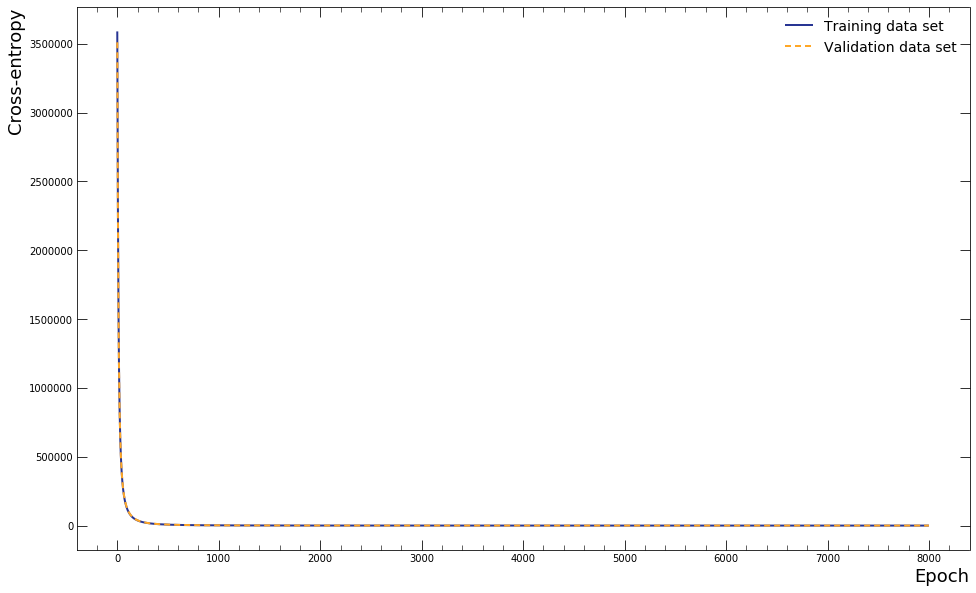

In [21]:
# Train neural networks
history = train_nn(model, x_train, x_train, 1024, "mse", model_name, x_val).history
plot_loss(history)

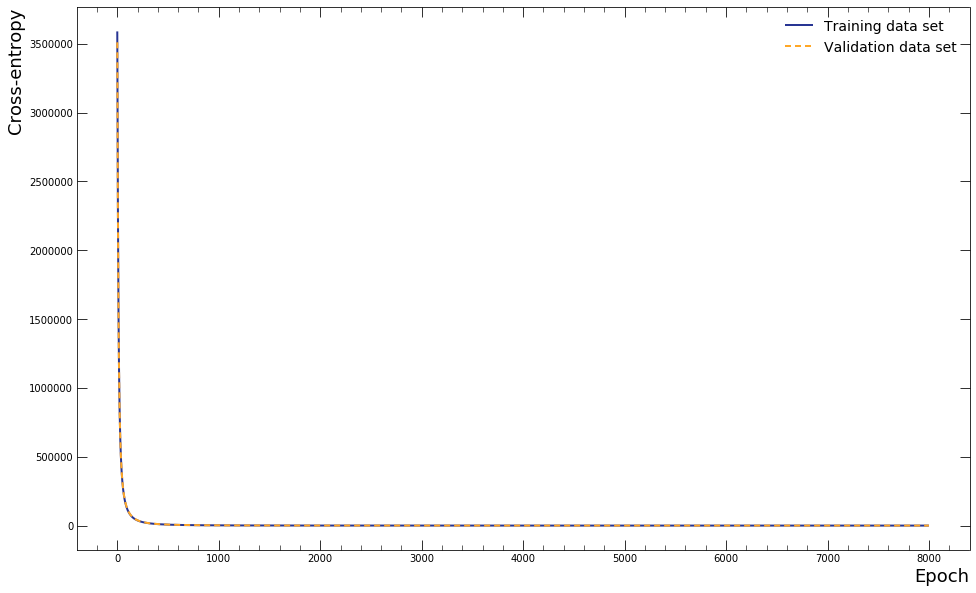

In [22]:
plot_loss(history)

## Training Set

In [23]:
# Generate predictions

model = load_model("%s.h5" % (model_name))

x_train_new = []
lumi_new = []
lumi = data[str(runs[0])]['lumiid'] 

for l in range(len(x_train)):
    if not 0 in x_train[l]:
        x_train_new.append(x_train[l])
        for i in range(WINDOW):
            lumi_new.append(lumi[l+i])
                
reconstructed = model.predict(np.array(x_train))

error = abs(x_train-reconstructed)/x_train

In [24]:
error_reformat = []
for i in range(6):
    error_reformat.append([])

for i in range(len(error)):
    for j in range(6):
        if i == len(error)-1:
            for val in error[i][WINDOW*j:WINDOW+WINDOW*j]:
                error_reformat[j].append(val)
        else:
            error_reformat[j].append(error[i][WINDOW*j])
            
inp = []
outp = []
for i in range(6):
    inp.append([])
    outp.append([])
    
for i in range(len(reconstructed)):
    for j in range(6):
        if i == len(reconstructed)-1:
            for val in reconstructed[i][WINDOW*j:WINDOW+WINDOW*j]:
                outp[j].append(val)
            for val in x_train_new[i][WINDOW*j:WINDOW+WINDOW*j]:
                inp[j].append(val)
        else:
            outp[j].append(reconstructed[i][WINDOW*j])
            inp[j].append(x_train_new[i][WINDOW*j])

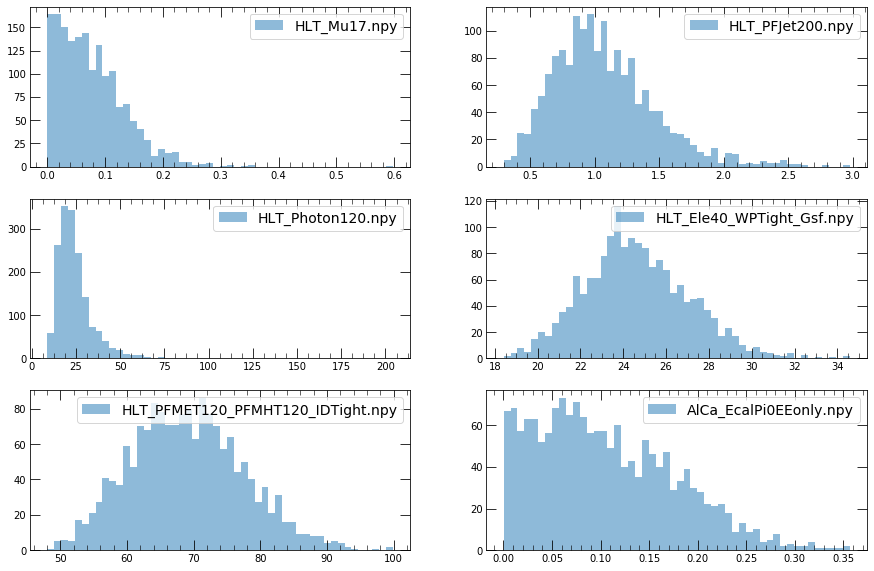

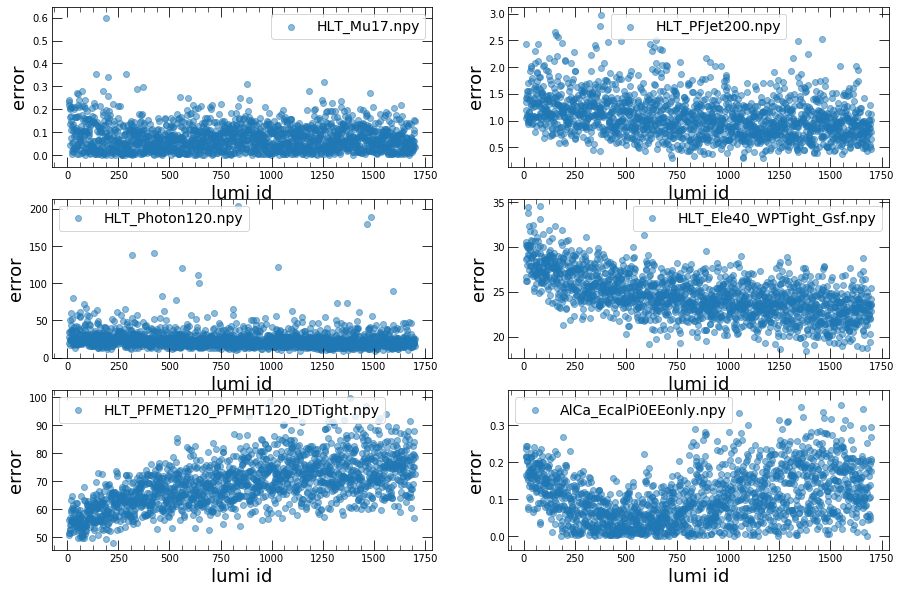

In [25]:
labels = data['HLT']

#bins = np.linspace(0,1,50)
bins = 50
plt.figure(figsize=[15,10])
for i in range(len(error_reformat)):
    plt.subplot(3,2,i+1)
    plt.hist(error_reformat[i],bins=bins,label=labels[i],alpha=.5)
    plt.legend()

#lumi = np.linspace(0,len(error_reformat[0]),len(error_reformat[0]))
plt.figure(figsize=[15,10])
for i in range(0,6):
    plt.subplot(3,2,i+1)
    plt.scatter(lumi,error_reformat[i],label=labels[i],alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('error')
    plt.legend()    

plt.show()

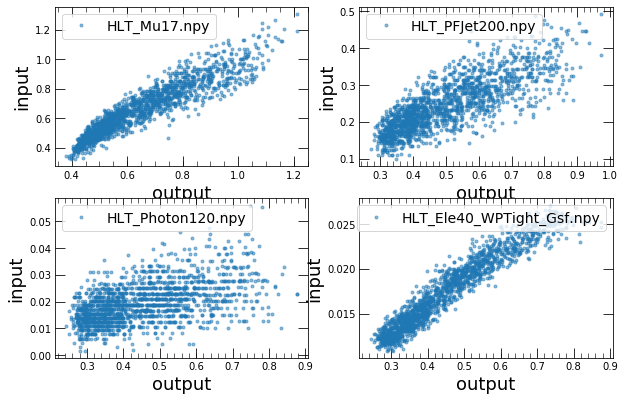

In [26]:
plt.figure(figsize=[10,10])
for i in range(0,4):
    plt.subplot(3,2,i+1)
    plt.plot(outp[i],inp[i],label=labels[i], linestyle='',marker='o', markersize=3, alpha=0.5)
    #plt.scatter(lumi,outp[i],label='output',alpha=.5)
    plt.xlabel('output')
    plt.ylabel('input')
    #plt.xlim(0,1.8)
    #plt.ylim(0,1.8)
    plt.legend()    

plt.show()

## Test Data

In [27]:
# Generate predictions

model = load_model("%s.h5" % (model_name))

x_test_new = []
for l in x_test:
    if not 0 in l:
        x_test_new.append(l)
                
reconstructed = model.predict(np.array(x_test_new))

error = abs(x_test_new-reconstructed)/x_test_new

In [28]:
error_reformat = []
for i in range(6):
    error_reformat.append([])

for i in range(len(error)):
    #print(len(error_reformat[0]))
    for j in range(6):
        if i == len(error)-1:
            for val in error[i][WINDOW*j:WINDOW+WINDOW*j]:
                error_reformat[j].append(val)
        else:
            error_reformat[j].append(error[i][WINDOW*j])
            
inp = []
outp = []
for i in range(6):
    inp.append([])
    outp.append([])
    
for i in range(len(reconstructed)):
    for j in range(6):
        if i == len(reconstructed)-1:
            for val in reconstructed[i][WINDOW*j:WINDOW+WINDOW*j]:
                outp[j].append(val)
            for val in x_test_new[i][WINDOW*j:WINDOW+WINDOW*j]:
                inp[j].append(val)
        else:
            outp[j].append(reconstructed[i][WINDOW*j])
            inp[j].append(x_test_new[i][WINDOW*j])

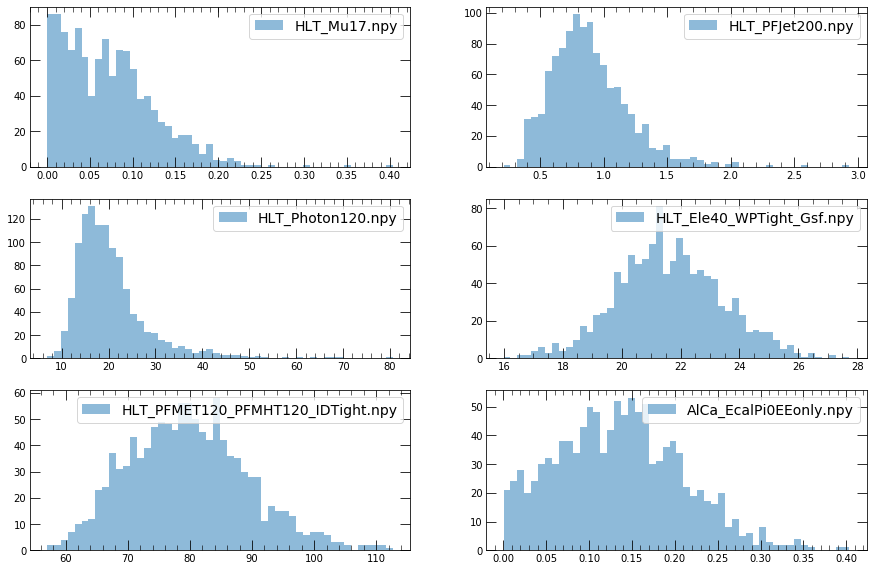

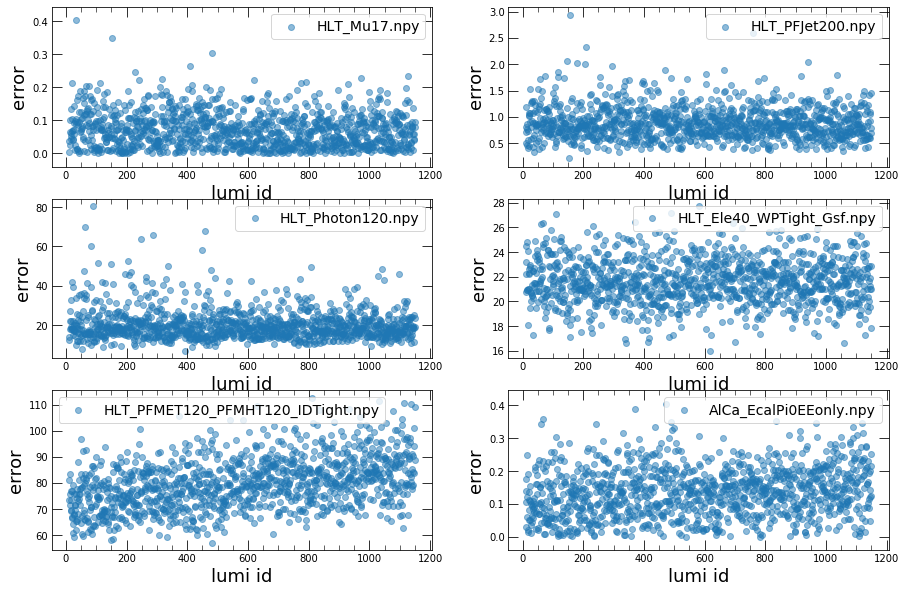

In [29]:
labels = data['HLT']

#bins = np.linspace(0,1,50)
bins = 50
plt.figure(figsize=[15,10])
for i in range(len(error_reformat)):
    plt.subplot(3,2,i+1)
    plt.hist(error_reformat[i],bins=bins,label=labels[i],alpha=.5)
    plt.legend()

lumi = data[str(runs[2])]['lumiid'] 
#lumi = np.linspace(0,len(error_reformat[0]),len(error_reformat[0]))
plt.figure(figsize=[15,10])
for i in range(0,6):
    plt.subplot(3,2,i+1)
    plt.scatter(lumi,error_reformat[i],label=labels[i],alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('error')
    plt.legend()    

plt.show()

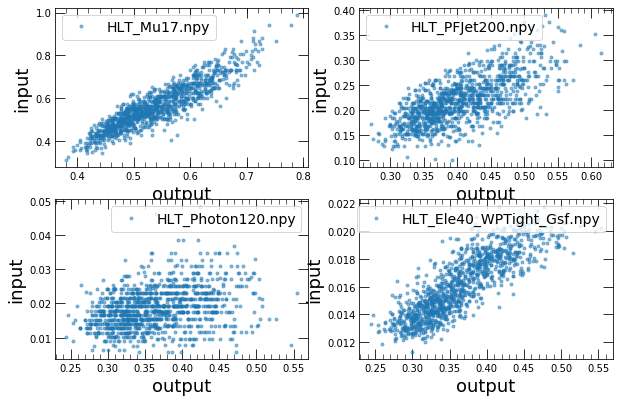

In [30]:
plt.figure(figsize=[10,10])
for i in range(0,4):
    plt.subplot(3,2,i+1)
    plt.plot(outp[i],inp[i],label=labels[i], linestyle='',marker='o', markersize=3, alpha=0.5)
    #plt.scatter(lumi,outp[i],label='output',alpha=.5)
    plt.xlabel('output')
    plt.ylabel('input')
    #plt.xlim(0,1.8)
    #plt.ylim(0,1.8)
    plt.legend()    

plt.show()

In [31]:
# plt.figure(figsize=[15,10])
# for i in range(0,4):
#     plt.subplot(3,2,i+1)
#     plt.scatter(lumi,inp[i],label='input',alpha=.5)
#     plt.scatter(lumi,outp[i]/max(outp[i]),label='output',alpha=.5)
#     plt.xlabel('index')
#     plt.ylabel('value')
#     plt.legend()    

# plt.show()

In [32]:
# for i in range(len(outp)):
#     for j in range(i+1,len(outp)):
#         print(sum(np.array(outp[i]/max(outp[i]))-np.array(outp[j]/max(outp[j]))))

## Fake Bad Data

In [33]:
bad = np.array(data[str(runs[2])]['bad_samples'])

In [34]:
bad_new = []
for l in bad:
    if not 0 in l:
        bad_new.append(l)
                
reconstructed_bad = model.predict(np.array(bad_new))

error_bad = abs(bad_new-reconstructed_bad)/bad_new

In [35]:
error_reformat_bad = []
for i in range(6):
    error_reformat_bad.append([])

for i in range(len(error_bad)):
    for j in range(6):
        if i == len(error_bad)-1:
            for val in error_bad[i][WINDOW*j:WINDOW+WINDOW*j]:
                error_reformat_bad[j].append(val)
        else:
            error_reformat_bad[j].append(error_bad[i][WINDOW*j])
            
inp_bad = []
outp_bad = []
for i in range(6):
    inp_bad.append([])
    outp_bad.append([])
    
for i in range(len(reconstructed_bad)):
    for j in range(6):
        if i == len(reconstructed_bad)-1:
            for val in reconstructed_bad[i][WINDOW*j:WINDOW+WINDOW*j]:
                outp_bad[j].append(val)
            for val in bad_new[i][WINDOW*j:WINDOW+WINDOW*j]:
                inp_bad[j].append(val)
        else:
            outp_bad[j].append(reconstructed_bad[i][WINDOW*j])
            inp_bad[j].append(bad_new[i][WINDOW*j])
            
        

1129 1129 1129


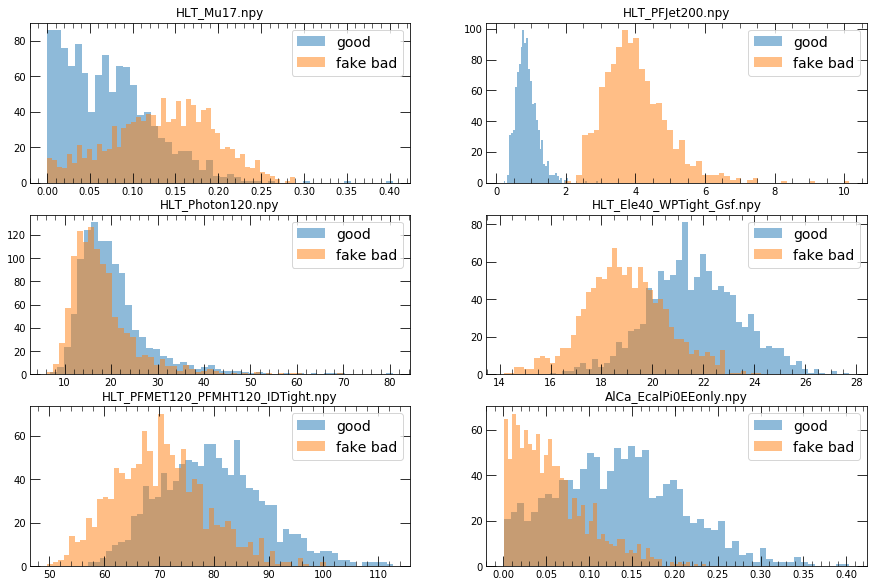

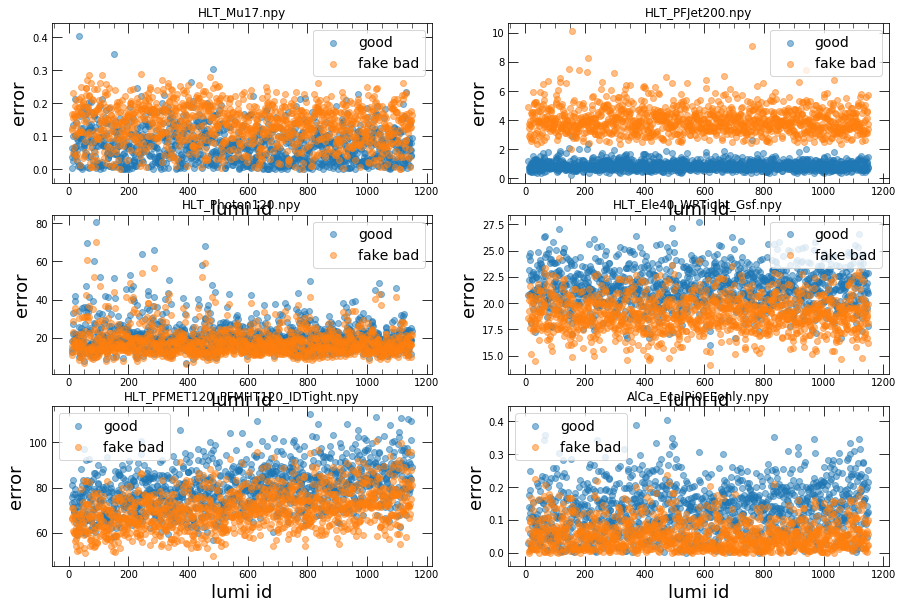

In [36]:
labels = data['HLT']

#bins = np.linspace(0,1,50)
bins = 50
plt.figure(figsize=[15,10])
for i in range(len(error_reformat_bad)):
    plt.subplot(3,2,i+1)
    plt.hist(error_reformat[i],bins=bins,label='good',alpha=.5)
    plt.hist(error_reformat_bad[i],bins=bins,label='fake bad',alpha=.5)
    plt.legend()
    plt.title(labels[i])

lumi = data[str(runs[2])]['lumiid'] 
print(len(error_reformat_bad[0]),len(error_reformat[0]),len(lumi))
#lumi = np.linspace(0,len(error_reformat_bad[0]),len(error_reformat_bad[0]))
plt.figure(figsize=[15,10])
for i in range(0,6):
    plt.subplot(3,2,i+1)
    plt.scatter(lumi,error_reformat[i],label = 'good', alpha =.5)
    plt.scatter(lumi,error_reformat_bad[i],label='fake bad',alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('error')
    plt.legend()    
    plt.title(labels[i])

plt.show()

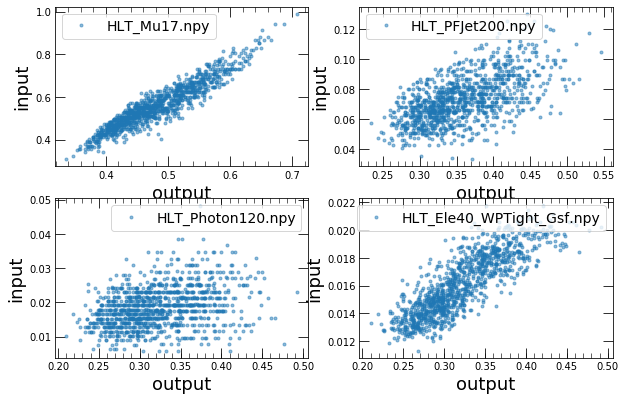

In [37]:
plt.figure(figsize=[10,10])
for i in range(0,4):
    plt.subplot(3,2,i+1)
    plt.plot(outp_bad[i],inp_bad[i],label=labels[i], linestyle='',marker='o', markersize=3, alpha=0.5)
    plt.xlabel('output')
    plt.ylabel('input')
    #plt.xlim(0,2)
    #plt.ylim(0,2)
    plt.legend()    

plt.show()

In [38]:
# plt.figure(figsize=[15,10])
# for i in range(0,4):
#     plt.subplot(3,2,i+1)
#     plt.scatter(lumi,inp_bad[i],label='inp_badut',alpha=.5)
#     plt.scatter(lumi,outp_bad[i]/max(outp_bad[i]),label='outp_badut',alpha=.5)
#     plt.xlabel('index')
#     plt.ylabel('value')
#     plt.legend()    

# plt.show()

In [39]:
# labels = data['HLT']

# #bins = np.linspace(0,1,50)
# bins = 50
# plt.figure(figsize=[15,10])
# for i in range(len(error_reformat_bad)):
#     plt.subplot(3,2,i+1)
#     plt.hist(error_reformat_bad[i],bins=bins,label='bad',alpha=.5)
#     plt.hist(error_reformat[i],bins=bins,label='good',alpha=.5)
#     plt.legend()

# # lumi = data[str(runs[0])]['lumiid'] 
# # print(len(error_reformat_bad[0]),len(lumi))
# # #lumi = np.linspace(0,len(error_reformat_bad[0]),len(error_reformat_bad[0]))
# # plt.figure(figsize=[15,10])
# # for i in range(0,4):
# #     plt.subplot(3,2,i+1)
# #     plt.scatter(lumi,error_reformat_bad[i],label='bad',alpha=.5)
# #     plt.scatter(lumi,error_reformat[i],label='good',alpha=.5)
# #     plt.xlabel('lumi id')
# #     plt.ylabel('error')
# #     plt.legend()    

# plt.show()

## Fake Bad Data - ALL

In [40]:
bad = np.array(data[str(runs[2])]['all_bad_samples'])

In [41]:
bad_new = []
for l in bad:
    if not 0 in l:
        bad_new.append(l)
                
reconstructed_bad = model.predict(np.array(bad_new))

error_bad = abs(bad_new-reconstructed_bad)/bad_new

In [42]:
error_reformat_bad = []
for i in range(6):
    error_reformat_bad.append([])

for i in range(len(error_bad)):
    for j in range(6):
        if i == len(error_bad)-1:
            for val in error_bad[i][WINDOW*j:WINDOW+WINDOW*j]:
                error_reformat_bad[j].append(val)
        else:
            error_reformat_bad[j].append(error_bad[i][WINDOW*j])
            
inp_bad = []
outp_bad = []
for i in range(6):
    inp_bad.append([])
    outp_bad.append([])
    
for i in range(len(reconstructed_bad)):
    for j in range(6):
        if i == len(reconstructed_bad)-1:
            for val in reconstructed_bad[i][WINDOW*j:WINDOW+WINDOW*j]:
                outp_bad[j].append(val)
            for val in bad_new[i][WINDOW*j:WINDOW+WINDOW*j]:
                inp_bad[j].append(val)
        else:
            outp_bad[j].append(reconstructed_bad[i][WINDOW*j])
            inp_bad[j].append(bad_new[i][WINDOW*j])
            
        

1129 1129


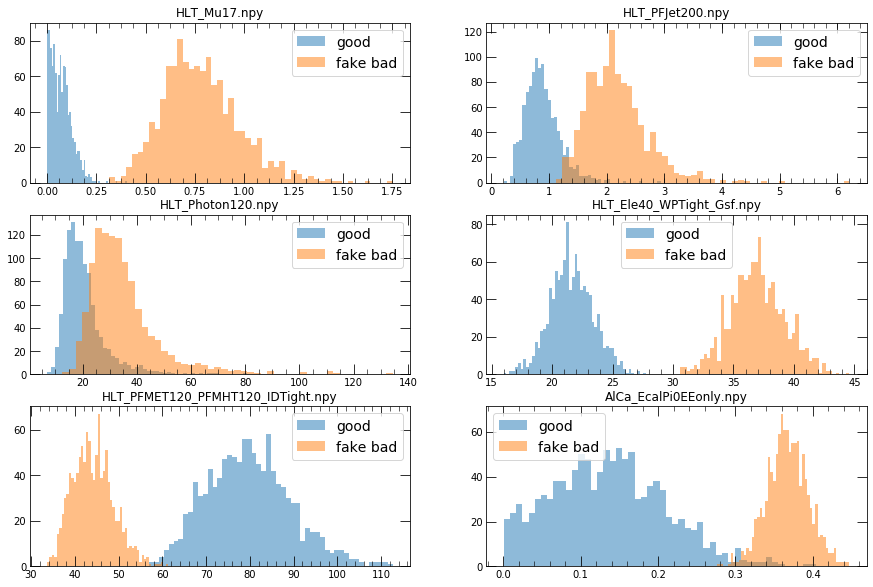

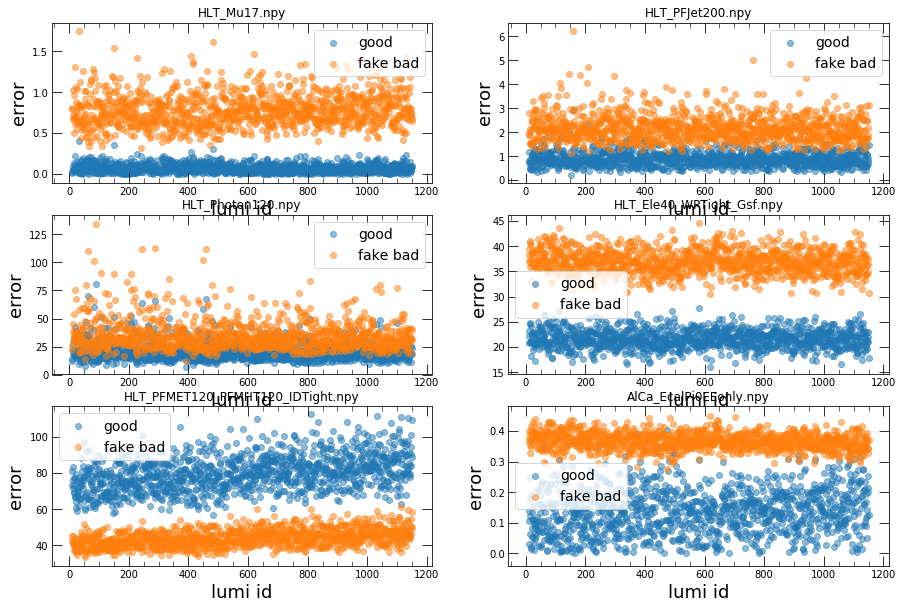

In [43]:
labels = data['HLT']

#bins = np.linspace(0,1,50)
bins = 50
plt.figure(figsize=[15,10])
for i in range(len(error_reformat_bad)):
    plt.subplot(3,2,i+1)
    plt.hist(error_reformat[i],bins=bins,label='good',alpha=.5)
    plt.hist(error_reformat_bad[i],bins=bins,label='fake bad',alpha=.5)
    plt.legend()
    plt.title(labels[i])

lumi = data[str(runs[2])]['lumiid'] 
print(len(error_reformat_bad[0]),len(lumi))
#lumi = np.linspace(0,len(error_reformat_bad[0]),len(error_reformat_bad[0]))
plt.figure(figsize=[15,10])
for i in range(0,6):
    plt.subplot(3,2,i+1)
    plt.scatter(lumi,error_reformat[i],label = 'good', alpha =.5)
    plt.scatter(lumi,error_reformat_bad[i],label='fake bad',alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('error')
    plt.legend()    
    plt.title(labels[i])

plt.show()

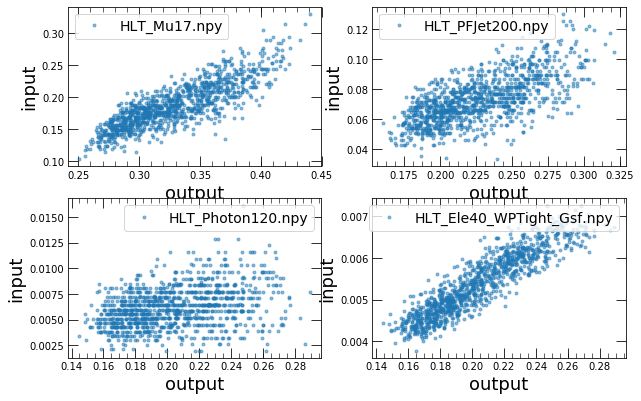

In [44]:
plt.figure(figsize=[10,10])
for i in range(0,4):
    plt.subplot(3,2,i+1)
    plt.plot(outp_bad[i],inp_bad[i],label=labels[i], linestyle='',marker='o', markersize=3, alpha=0.5)
    plt.xlabel('output')
    plt.ylabel('input')
    #plt.xlim(0,.6)
    #plt.ylim(0,.6)
    plt.legend()    

plt.show()

In [45]:
# plt.figure(figsize=[15,10])
# for i in range(0,4):
#     plt.subplot(3,2,i+1)
#     plt.scatter(lumi,inp_bad[i],label='input',alpha=.5)
#     plt.scatter(lumi,outp_bad[i]/max(outp_bad[i]),label='output',alpha=.5)
#     plt.xlabel('index')
#     plt.ylabel('value')
#     plt.legend()    

# plt.show()

In [46]:
# labels = data['HLT']

# #bins = np.linspace(0,1,50)
# bins = 50
# plt.figure(figsize=[15,10])
# for i in range(len(error_reformat_bad)):
#     plt.subplot(3,2,i+1)
#     plt.hist(error_reformat_bad[i],bins=bins,label='bad',alpha=.5)
#     plt.hist(error_reformat[i],bins=bins,label='good',alpha=.5)
#     plt.legend()

# # lumi = data[str(runs[0])]['lumiid'] 
# # print(len(error_reformat_bad[0]),len(lumi))
# # #lumi = np.linspace(0,len(error_reformat_bad[0]),len(error_reformat_bad[0]))
# # plt.figure(figsize=[15,10])
# # for i in range(0,4):
# #     plt.subplot(3,2,i+1)
# #     plt.scatter(lumi,error_reformat_bad[i],label='bad',alpha=.5)
# #     plt.scatter(lumi,error_reformat[i],label='good',alpha=.5)
# #     plt.xlabel('lumi id')
# #     plt.ylabel('error')
# #     plt.legend()    

# plt.show()

## Real Bad Data

In [47]:
bad_runs = [301480]

with open('normedAvg_bad.pickle', 'rb') as handle:
    baddata = pickle.load(handle)

x_test = np.array(baddata[str(bad_runs[0])]['samples'])

In [48]:
bad_new = []
lumi_new = []

lumiBad = baddata[str(bad_runs[0])]['lumiid']

for l in range(len(x_test)):
    if not 0 in x_test[l]:
        bad_new.append(x_test[l])
        for i in range(WINDOW):
            lumi_new.append(lumiBad[l+i])
            
lumiBad = []
for n in lumi_new:
    if n not in lumiBad:
        lumiBad.append(n)
    
                
reconstructed_bad = model.predict(np.array(bad_new))

error_bad = abs(bad_new-reconstructed_bad)/bad_new

In [49]:
error_reformat_bad = []
for i in range(6):
    error_reformat_bad.append([])

for i in range(len(error_bad)):
    for j in range(6):
        if i == len(error_bad)-1:
            for val in error_bad[i][WINDOW*j:WINDOW+WINDOW*j]:
                error_reformat_bad[j].append(val)
        else:
            error_reformat_bad[j].append(error_bad[i][WINDOW*j])
            
inp_bad = []
outp_bad = []
for i in range(6):
    inp_bad.append([])
    outp_bad.append([])
    
for i in range(len(reconstructed_bad)):
    for j in range(6):
        if i == len(reconstructed_bad)-1:
            for val in reconstructed_bad[i][WINDOW*j:WINDOW+WINDOW*j]:
                outp_bad[j].append(val)
            for val in bad_new[i][WINDOW*j:WINDOW+WINDOW*j]:
                inp_bad[j].append(val)
        else:
            outp_bad[j].append(reconstructed_bad[i][WINDOW*j])
            inp_bad[j].append(bad_new[i][WINDOW*j])
            
        

189 189


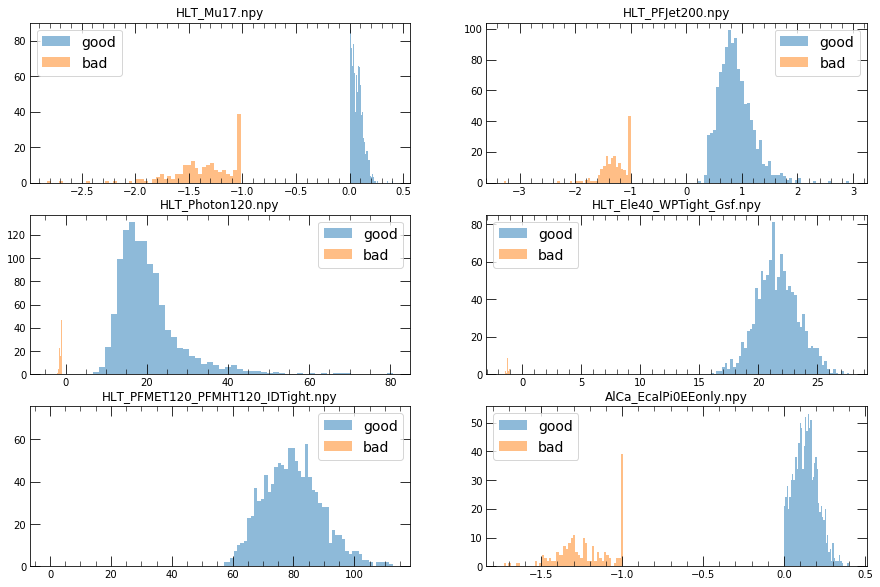

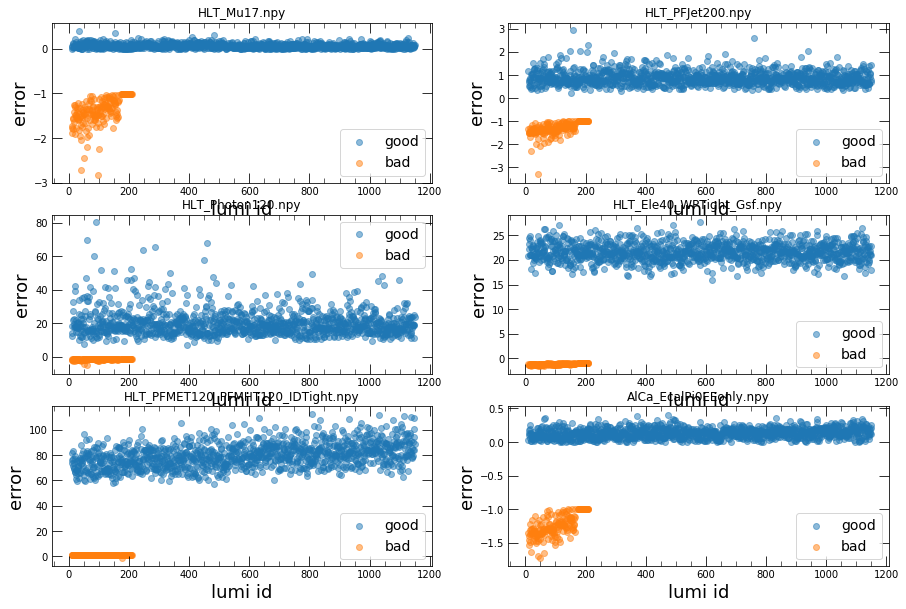

In [50]:
labels = data['HLT']

#bins = np.linspace(0,1,50)
bins = 50
plt.figure(figsize=[15,10])
for i in range(len(error_reformat_bad)):
    plt.subplot(3,2,i+1)
    plt.hist(error_reformat[i],bins=bins,label='good',alpha=.5)
    plt.hist(error_reformat_bad[i],bins=bins,label='bad',alpha=.5)
    plt.legend()
    plt.title(labels[i])

print(len(error_reformat_bad[0]),len(lumiBad))
plt.figure(figsize=[15,10])
for i in range(0,6):
    plt.subplot(3,2,i+1)
    plt.scatter(lumi,error_reformat[i],label = 'good', alpha =.5)
    plt.scatter(lumiBad,error_reformat_bad[i],label='bad',alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('error')
    plt.legend()    
    plt.title(labels[i])

plt.show()

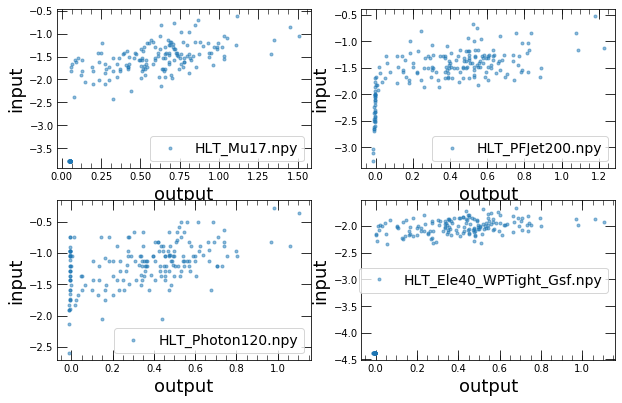

In [51]:
plt.figure(figsize=[10,10])
for i in range(0,4):
    plt.subplot(3,2,i+1)
    plt.plot(outp_bad[i],inp_bad[i],label=labels[i], linestyle='',marker='o', markersize=3, alpha=0.5)
    plt.xlabel('output')
    plt.ylabel('input')
    #plt.xlim(0,.6)
    #plt.ylim(0,.6)
    plt.legend()    

plt.show()

## Real Bad Data

In [52]:
bad_runs = [305588]

with open('normedAvg_bad.pickle', 'rb') as handle:
    baddata = pickle.load(handle)

x_test = np.array(baddata[str(bad_runs[0])]['samples'])

In [53]:
bad_new = []
lumi_new = []

lumiBad = baddata[str(bad_runs[0])]['lumiid']

for l in range(len(x_test)):
    if not 0 in x_test[l]:
        bad_new.append(x_test[l])
        for i in range(WINDOW):
            lumi_new.append(lumiBad[l+i])
            
lumiBad = []
for n in lumi_new:
    if n not in lumiBad:
        lumiBad.append(n)
    
                
reconstructed_bad = model.predict(np.array(bad_new))

error_bad = abs(bad_new-reconstructed_bad)/bad_new

In [54]:
error_reformat_bad = []
for i in range(6):
    error_reformat_bad.append([])

for i in range(len(error_bad)):
    for j in range(6):
        if i == len(error_bad)-1:
            for val in error_bad[i][WINDOW*j:WINDOW+WINDOW*j]:
                error_reformat_bad[j].append(val)
        else:
            error_reformat_bad[j].append(error_bad[i][WINDOW*j])
            
inp_bad = []
outp_bad = []
for i in range(6):
    inp_bad.append([])
    outp_bad.append([])
    
for i in range(len(reconstructed_bad)):
    for j in range(6):
        if i == len(reconstructed_bad)-1:
            for val in reconstructed_bad[i][WINDOW*j:WINDOW+WINDOW*j]:
                outp_bad[j].append(val)
            for val in bad_new[i][WINDOW*j:WINDOW+WINDOW*j]:
                inp_bad[j].append(val)
        else:
            outp_bad[j].append(reconstructed_bad[i][WINDOW*j])
            inp_bad[j].append(bad_new[i][WINDOW*j])
            
        

99 99


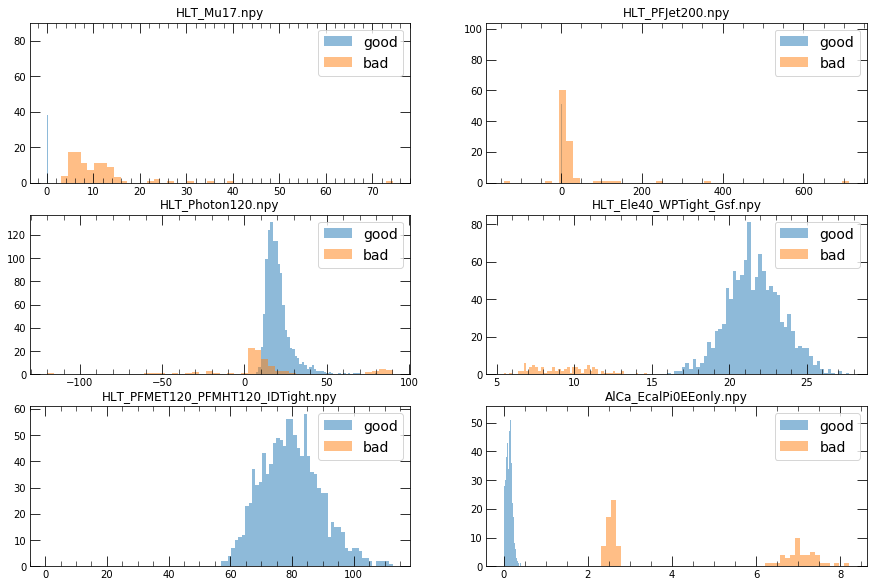

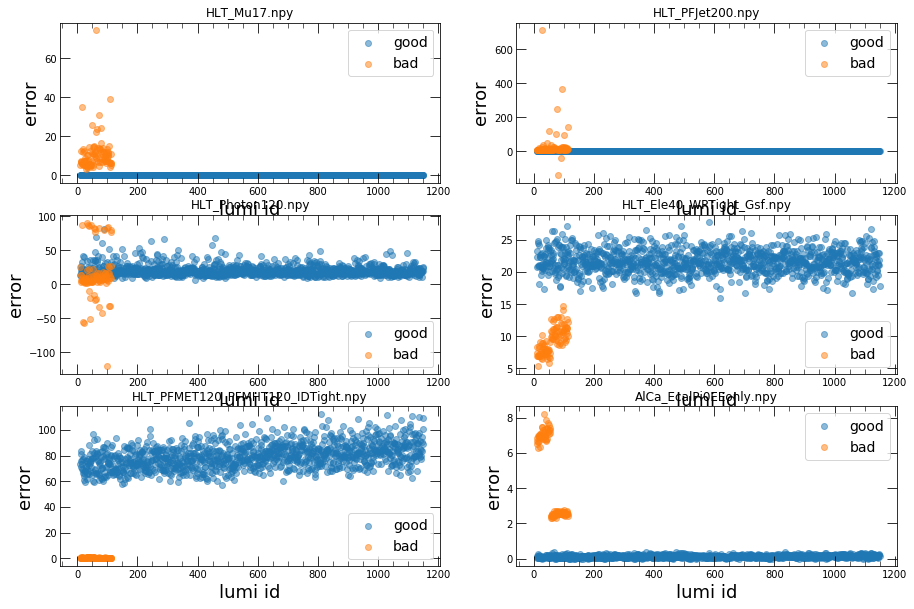

In [55]:
labels = data['HLT']

#bins = np.linspace(0,1,50)
bins = 50
plt.figure(figsize=[15,10])
for i in range(len(error_reformat_bad)):
    plt.subplot(3,2,i+1)
    plt.hist(error_reformat[i],bins=bins,label='good',alpha=.5)
    plt.hist(error_reformat_bad[i],bins=bins,label='bad',alpha=.5)
    plt.legend()
    plt.title(labels[i])

print(len(error_reformat_bad[0]),len(lumiBad))
plt.figure(figsize=[15,10])
for i in range(0,6):
    plt.subplot(3,2,i+1)
    plt.scatter(lumi,error_reformat[i],label = 'good', alpha =.5)
    plt.scatter(lumiBad,error_reformat_bad[i],label='bad',alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('error')
    plt.legend()    
    plt.title(labels[i])

plt.show()

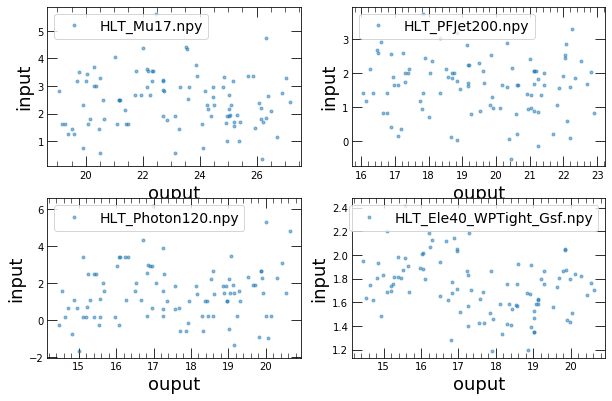

In [56]:
plt.figure(figsize=[10,10])
for i in range(0,4):
    plt.subplot(3,2,i+1)
    plt.plot(outp_bad[i],inp_bad[i],label=labels[i], linestyle='',marker='o', markersize=3, alpha=0.5)
    plt.xlabel('ouput')
    plt.ylabel('input')
    #plt.xlim(0,.6)
    #plt.ylim(0,.6)
    plt.legend()    

plt.show()